# <b>Expected Goal (xG)</b>
Expected goal (xG) model is a statistical method used to measure the quality of scoring opportunities in football (soccer). It assigns a probability value between 0 and 1 to each shot taken during a match, based on factors such as the location of the shot, the type of shot, and the situation leading up to the shot. The higher the xG value of a shot, the more likely it is to result in a goal. By analyzing xG data, analysts and coaches can gain insights into the performance of individual players and teams, and make strategic decisions to improve their game.

# <b>Expected Assists (xG)</b>
Expected assists (xA) measures the likelihood that a completed pass will become a goal assist. It considers several factors, including the type of pass and end point and length of pass. Adding up a player or team's expected assists gives us an indication of how many assists a player or team should have had, based on their build up and attacking play.

The following expected assists model is built using a logistic regression model that is powered by hundreds of thousands of passes from our historical Opta data and incorporates a number of variables that affect the likelihood of a given pass becoming an assist, the most important of which are listed below:

- Type of pass​ (e.g., cross, non-cross, header, through ball etc)
- Pattern of play (e.g., open play, corner, free kick, throw-in etc)
- Location of where the pass is received
- Location of where pass is made from
- Distance of the pass

The pattern of play and the type of pass played are particularly important to the likelihood of a pass becoming an assist and so there are sub models for the different interactions between these variables.

# <b> Explanation of the Data set</b>

- <b>id</b>: a unique identifier of the event

- <b>eventID</b>: the identifier of the event's type. Each eventId is associated with an event. 

- <b>eventName</b>: name of the event's type

- <b>subEventId</b>: the identifier of the subevent's type. Each subEventId is associated with a subevent name

- <b>subEventName</b>: the name of the subevent's type. Each event type is associated with a different set of subevent types. 

   - The specific details of the above three vaariables are present in the file "/kaggle/input/football-event- data/eventid2name.csv"
   

- <b>eventSec</b>: the time when the event occurs (in seconds since the beginning of the current half of the match)

- <b>tags</b>: a list of event tags, each one describes additional information about the event (e.g., accurate). Each event type is associated with a different set of tags. Details of tag and associaetd labels and descriptions is given in the file "/kaggle/input/football-event-data/tags2name.csv"

- <b>playerID</b>: the identifier of the player who generated the event

- <b>positions</b>: the origin and destination positions associated with the event. Each position is a pair of coordinates (x, y). The x and y coordinates are always in the range [0, 100] and indicate the percentage of the field from the perspective of the attacking team. In particular, the value of the x coordinate indicates the event's nearness (in percentage) to the opponent's goal, while the value of the y coordinates indicates the event's nearness (in percentage) to the right side of the field

- <b>matchId</b>: the identifier of the match the event refers to

- <b>teamId</b>: the identifier of the player's team

- <b>matchPeriod</b>: the period of the match. It can be "1H" (first half of the match), "2H" (second half of the match), "E1" (first extra time), "E2" (second extra time) or "P" (penalties time)

# <b>Data Loading and Pre-Processing</b>

In [ ]:
# !pip install numpy
# !pip install pandas
# !pip install seaborn
# !pip install matplotlib
# !pip install statsmodels
# !pip install scikit-learn
# !pip install tabulate
# !pip install xgboost
# !pip install lightgbm
# !pip install Jinja2

In [23]:
import numpy as np 
import pandas as pd
import seaborn as sns
import json
#Plotting
import matplotlib.pyplot as plt
#Statistical fitting of models
import statsmodels.api as sm
import statsmodels.formula.api as smf
import time

In [4]:
# Loading data for the English League
with open('football_datasets/events_England.json') as f:
    data_England = json.load(f)

# Converting the laoded into datframe
event_England = pd.DataFrame(data_England)

event_England

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175
...,...,...,...,...,...,...,...,...,...,...,...,...
643145,5,Ball out of the field,[],0,"[{'y': 32, 'x': 0}, {'y': 100, 'x': 100}]",2500098,Interruption,1623,2H,2796.732525,50,251596409
643146,3,Corner,"[{'id': 302}, {'id': 801}, {'id': 1801}]",70965,"[{'y': 100, 'x': 100}, {'y': 47, 'x': 88}]",2500098,Free Kick,1633,2H,2829.821084,30,251596232
643147,1,Air duel,"[{'id': 701}, {'id': 1802}]",7919,"[{'y': 53, 'x': 12}, {'y': 50, 'x': 14}]",2500098,Duel,1623,2H,2831.211419,10,251596410
643148,1,Air duel,"[{'id': 703}, {'id': 1801}]",8005,"[{'y': 47, 'x': 88}, {'y': 50, 'x': 86}]",2500098,Duel,1633,2H,2832.434399,10,251596234


In [5]:
# Loading data for the French League
with open('football_datasets/events_France.json') as f:
    data_France = json.load(f)

# Converting the laoded into datframe
event_France = pd.DataFrame(data_France)

event_France

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],253784,"[{'y': 51, 'x': 50}, {'y': 46, 'x': 31}]",2500686,Pass,3799,1H,1.935181,85,176505119
1,8,High pass,[{'id': 1801}],29474,"[{'y': 46, 'x': 31}, {'y': 74, 'x': 68}]",2500686,Pass,3799,1H,3.599295,83,176505121
2,1,Air duel,"[{'id': 703}, {'id': 1801}]",253784,"[{'y': 74, 'x': 68}, {'y': 54, 'x': 72}]",2500686,Duel,3799,1H,6.827043,10,176505122
3,1,Air duel,"[{'id': 701}, {'id': 1802}]",56441,"[{'y': 26, 'x': 32}, {'y': 46, 'x': 28}]",2500686,Duel,3772,1H,6.985577,10,176505017
4,1,Ground attacking duel,"[{'id': 702}, {'id': 1801}]",366760,"[{'y': 54, 'x': 72}, {'y': 55, 'x': 73}]",2500686,Duel,3799,1H,9.511272,11,176505124
...,...,...,...,...,...,...,...,...,...,...,...,...
632802,10,Shot,"[{'id': 101}, {'id': 401}, {'id': 201}, {'id':...",405977,"[{'y': 65, 'x': 87}, {'y': 100, 'x': 100}]",2501065,Shot,19830,2H,2821.203869,100,253316980
632803,9,Save attempt,"[{'id': 101}, {'id': 1208}, {'id': 1802}]",25521,"[{'y': 0, 'x': 0}, {'y': 35, 'x': 13}]",2501065,Save attempt,3795,2H,2824.817116,91,253316978
632804,8,Simple pass,[{'id': 1801}],295761,"[{'y': 52, 'x': 50}, {'y': 47, 'x': 44}]",2501065,Pass,3795,2H,2888.383858,85,253316981
632805,8,Simple pass,[{'id': 1801}],249926,"[{'y': 47, 'x': 44}, {'y': 8, 'x': 41}]",2501065,Pass,3795,2H,2889.654402,85,253316982


In [6]:
# Loading data for Italian League
with open('football_datasets/events_Italy.json') as f:
    data_Italy = json.load(f)

# Converting the laoded into datframe
event_Italy = pd.DataFrame(data_Italy)

event_Italy

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],8327,"[{'y': 52, 'x': 49}, {'y': 44, 'x': 43}]",2575959,Pass,3158,1H,2.530536,85,180423957
1,8,Simple pass,[{'id': 1801}],20438,"[{'y': 44, 'x': 43}, {'y': 17, 'x': 36}]",2575959,Pass,3158,1H,3.768418,85,180423958
2,7,Touch,[],8306,"[{'y': 17, 'x': 36}, {'y': 56, 'x': 78}]",2575959,Others on the ball,3158,1H,4.868265,72,180423959
3,1,Ground attacking duel,"[{'id': 504}, {'id': 703}, {'id': 1801}]",8306,"[{'y': 56, 'x': 78}, {'y': 15, 'x': 64}]",2575959,Duel,3158,1H,8.114676,11,180423960
4,1,Ground attacking duel,"[{'id': 503}, {'id': 703}, {'id': 1801}]",8306,"[{'y': 15, 'x': 64}, {'y': 15, 'x': 72}]",2575959,Duel,3158,1H,8.647892,11,180423961
...,...,...,...,...,...,...,...,...,...,...,...,...
647367,3,Free kick cross,"[{'id': 801}, {'id': 1801}]",70974,"[{'y': 23, 'x': 75}, {'y': 65, 'x': 95}]",2576338,Free Kick,3193,2H,2870.982660,32,253567160
647368,1,Ground loose ball duel,"[{'id': 702}, {'id': 1801}]",14745,"[{'y': 35, 'x': 5}, {'y': 36, 'x': 3}]",2576338,Duel,3185,2H,2872.101142,13,253567161
647369,1,Ground loose ball duel,"[{'id': 702}, {'id': 1801}]",413041,"[{'y': 65, 'x': 95}, {'y': 64, 'x': 97}]",2576338,Duel,3193,2H,2872.990437,13,253567163
647370,1,Air duel,"[{'id': 703}, {'id': 1801}]",20927,"[{'y': 36, 'x': 3}, {'y': 100, 'x': 100}]",2576338,Duel,3185,2H,2874.049206,10,253567162


In [7]:
# Loading data for Spanish league
with open('football_datasets/events_Spain.json') as f:
    data_Spain = json.load(f)

# Converting the laoded into datframe
event_Spain = pd.DataFrame(data_Spain)

event_Spain

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],3542,"[{'y': 61, 'x': 37}, {'y': 50, 'x': 50}]",2565548,Pass,682,1H,2.994582,85,180864419
1,8,Simple pass,[{'id': 1801}],274435,"[{'y': 50, 'x': 50}, {'y': 30, 'x': 45}]",2565548,Pass,682,1H,3.137020,85,180864418
2,8,Simple pass,[{'id': 1801}],364860,"[{'y': 30, 'x': 45}, {'y': 12, 'x': 38}]",2565548,Pass,682,1H,6.709668,85,180864420
3,8,Simple pass,[{'id': 1801}],3534,"[{'y': 12, 'x': 38}, {'y': 69, 'x': 32}]",2565548,Pass,682,1H,8.805497,85,180864421
4,8,Simple pass,[{'id': 1801}],3695,"[{'y': 69, 'x': 32}, {'y': 37, 'x': 31}]",2565548,Pass,682,1H,14.047492,85,180864422
...,...,...,...,...,...,...,...,...,...,...,...,...
628654,8,Simple pass,[{'id': 1801}],20623,"[{'y': 25, 'x': 66}, {'y': 2, 'x': 88}]",2565927,Pass,682,2H,2939.077491,85,253302671
628655,7,Acceleration,[{'id': 1801}],122832,"[{'y': 2, 'x': 88}, {'y': 21, 'x': 97}]",2565927,Others on the ball,682,2H,2940.515560,70,253302673
628656,8,Cross,"[{'id': 401}, {'id': 1802}]",122832,"[{'y': 21, 'x': 97}, {'y': 26, 'x': 92}]",2565927,Pass,682,2H,2942.098761,80,253302674
628657,8,Simple pass,[{'id': 1801}],40756,"[{'y': 74, 'x': 8}, {'y': 56, 'x': 9}]",2565927,Pass,675,2H,2943.089232,85,253302698


In [8]:
# Loading data for the German league
with open('football_datasets/events_Germany.json') as f:
    data_Germany = json.load(f)

# Converting the laoded into datframe
event_Germany = pd.DataFrame(data_Germany)

event_Germany

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],15231,"[{'y': 50, 'x': 50}, {'y': 48, 'x': 50}]",2516739,Pass,2446,1H,2.409746,85,179896442
1,8,Simple pass,[{'id': 1801}],14786,"[{'y': 48, 'x': 50}, {'y': 22, 'x': 22}]",2516739,Pass,2446,1H,2.506082,85,179896443
2,8,Simple pass,[{'id': 1801}],14803,"[{'y': 22, 'x': 22}, {'y': 46, 'x': 6}]",2516739,Pass,2446,1H,6.946706,85,179896444
3,8,Simple pass,[{'id': 1801}],14768,"[{'y': 46, 'x': 6}, {'y': 10, 'x': 20}]",2516739,Pass,2446,1H,10.786491,85,179896445
4,8,Simple pass,[{'id': 1801}],14803,"[{'y': 10, 'x': 20}, {'y': 4, 'x': 27}]",2516739,Pass,2446,1H,12.684514,85,179896446
...,...,...,...,...,...,...,...,...,...,...,...,...
519402,1,Ground attacking duel,"[{'id': 702}, {'id': 1801}]",15317,"[{'y': 9, 'x': 91}, {'y': 6, 'x': 90}]",2517044,Duel,2463,2H,2825.097992,11,251206867
519403,1,Ground defending duel,"[{'id': 703}, {'id': 1801}]",14804,"[{'y': 94, 'x': 10}, {'y': 95, 'x': 0}]",2517044,Duel,2451,2H,2825.519102,12,251206788
519404,1,Ground attacking duel,"[{'id': 701}, {'id': 1802}]",15317,"[{'y': 6, 'x': 90}, {'y': 5, 'x': 100}]",2517044,Duel,2463,2H,2826.053788,11,251206868
519405,8,Simple pass,[{'id': 1802}],14804,"[{'y': 95, 'x': 0}, {'y': 93, 'x': 5}]",2517044,Pass,2451,2H,2828.080925,85,251206790


In [9]:
# Combining all our dataframes to make one consolidated event data set for the 5 maor leagues
event_data = pd.concat([event_England, event_France, event_Germany, event_Italy, event_Spain])

# Reset the index of the resulting dataframe
event_data = event_data.reset_index(drop=True)

event_data

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175
...,...,...,...,...,...,...,...,...,...,...,...,...
3071390,8,Simple pass,[{'id': 1801}],20623,"[{'y': 25, 'x': 66}, {'y': 2, 'x': 88}]",2565927,Pass,682,2H,2939.077491,85,253302671
3071391,7,Acceleration,[{'id': 1801}],122832,"[{'y': 2, 'x': 88}, {'y': 21, 'x': 97}]",2565927,Others on the ball,682,2H,2940.515560,70,253302673
3071392,8,Cross,"[{'id': 401}, {'id': 1802}]",122832,"[{'y': 21, 'x': 97}, {'y': 26, 'x': 92}]",2565927,Pass,682,2H,2942.098761,80,253302674
3071393,8,Simple pass,[{'id': 1801}],40756,"[{'y': 74, 'x': 8}, {'y': 56, 'x': 9}]",2565927,Pass,675,2H,2943.089232,85,253302698


In [10]:
# Loading the player rank data
with open('football_datasets/playerank.json') as f:
    data_player_rank = json.load(f)

# Converting the laoded into datframe
player_rank_df = pd.DataFrame(data_player_rank)
player_rank_df

,goalScored,playerankScore,matchId,playerId,roleCluster,minutesPlayed
0,0,0.0053,2057991,10014,right CB,90
1,0,0.0009,2057992,10014,right CB,41
2,0,-0.0013,2057998,100140,central MF,90
3,0,0.0031,2058000,100140,left CB,90
4,0,0.0035,2499869,10108,right CB,90
...,...,...,...,...,...,...
46892,0,0.0179,2576295,99902,left FW,23
46893,0,0.0020,2576305,99902,central MF,32
46894,0,-0.0029,2576318,99902,left FW,70
46895,0,0.0253,2576325,99902,central MF,90


Adding player rank and to the event_data dataset so that quality of the player taking the shot is included as a feature in our data. Joining the event_data and player rank data on the playerId column. To achieve this purpose we will be performing a <b>left</b> join between the two dataframes using <b>matchId</b> and <b>playerId</b> columns.


In [11]:
event_data_merged = pd.merge(event_data, player_rank_df[['matchId','playerId','playerankScore']], 
                             on = ['matchId','playerId'], 
                             how = 'left')

event_data_merged

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,playerankScore
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171,0.0255
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172,0.0058
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173,-0.0039
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174,0.0526
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175,0.0281
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3071390,8,Simple pass,[{'id': 1801}],20623,"[{'y': 25, 'x': 66}, {'y': 2, 'x': 88}]",2565927,Pass,682,2H,2939.077491,85,253302671,0.0255
3071391,7,Acceleration,[{'id': 1801}],122832,"[{'y': 2, 'x': 88}, {'y': 21, 'x': 97}]",2565927,Others on the ball,682,2H,2940.515560,70,253302673,-0.0043
3071392,8,Cross,"[{'id': 401}, {'id': 1802}]",122832,"[{'y': 21, 'x': 97}, {'y': 26, 'x': 92}]",2565927,Pass,682,2H,2942.098761,80,253302674,-0.0043
3071393,8,Simple pass,[{'id': 1801}],40756,"[{'y': 74, 'x': 8}, {'y': 56, 'x': 9}]",2565927,Pass,675,2H,2943.089232,85,253302698,-0.0008


### Filtering out Shots Data
The goal is filter out all 'Shot' events excluding free kicks, penalty kicks and headers. For this, we apply a filter on the subevents to capture only 'Shot' events. But these events also contain headers. Headed shots can be identified using tags. Tag for headed shots is 403.

In [12]:
# Filtering out all the shots from our dataset
shots_df = event_data_merged[event_data_merged['subEventName']=='Shot'].reset_index(drop=True)

shots_df

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,playerankScore
0,10,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",25413,"[{'y': 41, 'x': 88}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,94.595788,100,177959212,0.0255
1,10,Shot,"[{'id': 401}, {'id': 201}, {'id': 1211}, {'id'...",26150,"[{'y': 52, 'x': 85}, {'y': 100, 'x': 100}]",2499719,Shot,1631,1H,179.854785,100,177959247,0.0069
2,10,Shot,"[{'id': 101}, {'id': 403}, {'id': 201}, {'id':...",14763,"[{'y': 52, 'x': 96}, {'y': 100, 'x': 100}]",2499719,Shot,1631,1H,254.745027,100,177959280,0.0127
3,10,Shot,"[{'id': 401}, {'id': 201}, {'id': 1215}, {'id'...",7868,"[{'y': 33, 'x': 81}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,425.824035,100,177959289,0.0341
4,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1205}, {'id'...",7868,"[{'y': 30, 'x': 75}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,815.462015,100,177959429,0.0341
...,...,...,...,...,...,...,...,...,...,...,...,...,...
40456,10,Shot,"[{'id': 1901}, {'id': 402}, {'id': 2101}, {'id...",267134,"[{'y': 66, 'x': 93}, {'y': 0, 'x': 0}]",2565927,Shot,682,2H,1776.027412,100,253302272,0.0058
40457,10,Shot,"[{'id': 402}, {'id': 2101}, {'id': 1802}]",267134,"[{'y': 32, 'x': 90}, {'y': 0, 'x': 0}]",2565927,Shot,682,2H,1944.188119,100,253302329,0.0058
40458,10,Shot,"[{'id': 101}, {'id': 401}, {'id': 201}, {'id':...",134174,"[{'y': 25, 'x': 92}, {'y': 0, 'x': 0}]",2565927,Shot,682,2H,2385.837008,100,253302547,-0.0059
40459,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1206}, {'id'...",3321,"[{'y': 30, 'x': 82}, {'y': 100, 'x': 100}]",2565927,Shot,675,2H,2722.835144,100,253302642,0.0259


### Filtering out Assist Data From Shots Data

Estratti i seguenti parametri per il modello di Expected Assists:

- **Pass_Type**: Tipo di passaggio (es. cross, filtrante, ecc.), estratto da `subEventName`.
- **Pattern_of_Play**: Contesto del gioco (es. open play, calcio piazzato), derivato dai tag (`tag['id'] == 1801` per open play).
- **Pass_Start_X, Pass_Start_Y**: Coordinate iniziali del passaggio, estratte dalla colonna `positions`.
- **Pass_End_X, Pass_End_Y**: Coordinate finali del passaggio, estratte dalla colonna `positions`.
- **Pass_Distance**: Distanza euclidea tra il punto iniziale e finale del passaggio.
- **Pass_Angle**: Angolo del passaggio, calcolato usando l'arctangente della differenza tra le coordinate Y e X.
- **Proximity_to_Goal**: Distanza del punto finale del passaggio dalla porta avversaria (X = 100).
- **Goal_Angle**: Angolo tra il punto finale del passaggio e il centro della porta, calcolato con la trigonometria.
- **Player_Rank**: Punteggio del giocatore che effettua il passaggio, derivato dalla colonna `playerankScore`.
- **Receiving_Player_Rank**: Punteggio del giocatore che riceve il passaggio (se disponibile nei tag).
- **Match_Period**: Periodo della partita (es. 1H, 2H), codificato in one-hot dalla colonna `matchPeriod`.
- **Assist_Tag**: Variabile binaria che indica se il passaggio è etichettato come assist (`tag['id'] == 301`).
- **One-Hot Encoded Features**:
  - **Pass_Type**: Codifica one-hot per i diversi tipi di passaggi.
  - **Pattern_of_Play**: Codifica one-hot per i diversi pattern di gioco (es. open play, calcio piazzato).

In [13]:
# Filtering out all the passes from the dataset
passes_df = event_data_merged[event_data_merged['eventName'] == 'Pass'].reset_index(drop=True)

# Adding features
passes_df['Pass_Type'] = passes_df['subEventName']  # Type of pass (e.g., cross, through ball, etc.)
passes_df['Pattern_of_Play'] = passes_df['tags'].apply(
    lambda tags: 'Open Play' if any(tag['id'] == 1801 for tag in tags) else 'Set Piece'
)  # Pattern of play (e.g., open play, set piece)

# Extracting start and end positions
passes_df['Pass_Start_X'] = passes_df['positions'].apply(lambda pos: pos[0]['x'])  # Start X
passes_df['Pass_Start_Y'] = passes_df['positions'].apply(lambda pos: pos[0]['y'])  # Start Y
passes_df['Pass_End_X'] = passes_df['positions'].apply(lambda pos: pos[1]['x'] if len(pos) > 1 else None)  # End X
passes_df['Pass_End_Y'] = passes_df['positions'].apply(lambda pos: pos[1]['y'] if len(pos) > 1 else None)  # End Y

# Calculating pass distance
passes_df['Pass_Distance'] = passes_df.apply(
    lambda row: ((row['Pass_End_X'] - row['Pass_Start_X'])**2 + (row['Pass_End_Y'] - row['Pass_Start_Y'])**2)**0.5, axis=1
)

# Calculating pass angle
passes_df['Pass_Angle'] = passes_df.apply(
    lambda row: np.arctan2(row['Pass_End_Y'] - row['Pass_Start_Y'], row['Pass_End_X'] - row['Pass_Start_X']), axis=1
)

# Calculating proximity to goal
passes_df['Proximity_to_Goal'] = passes_df['Pass_End_X'].apply(lambda x: 100 - x if x is not None else None)

# Calculating goal angle
passes_df['Goal_Angle'] = passes_df.apply(
    lambda row: np.arctan2(abs(row['Pass_End_Y'] - 50), 100 - row['Pass_End_X']) if row['Pass_End_X'] is not None else None, axis=1
)

# Adding player rank
passes_df['Player_Rank'] = passes_df['playerankScore']

# Adding receiving player rank (if available)
passes_df['Receiving_Player_Rank'] = passes_df['tags'].apply(
    lambda tags: next((tag['value'] for tag in tags if 'Receiving_Player_Rank' in tag), None)
)

# Adding match period (one-hot encoded)
passes_df = pd.concat([passes_df, pd.get_dummies(passes_df['matchPeriod'], prefix='Match_Period')], axis=1)

# Adding assist tag (binary)
passes_df['Assist_Tag'] = passes_df['tags'].apply(lambda tags: 1 if any(tag['id'] == 301 for tag in tags) else 0)

# One-hot encoding pass type and pattern of play
passes_df = pd.concat([passes_df, pd.get_dummies(passes_df['Pass_Type'], prefix='Pass_Type')], axis=1)
passes_df = pd.concat([passes_df, pd.get_dummies(passes_df['Pattern_of_Play'], prefix='Pattern_of_Play')], axis=1)

# Display the resulting dataframe with the extracted features
passes_df[['Pass_Start_X', 'Pass_Start_Y', 'Pass_End_X', 'Pass_End_Y', 'Pass_Distance', 'Pass_Angle',
           'Proximity_to_Goal', 'Goal_Angle', 'Player_Rank', 'Receiving_Player_Rank', 'Assist_Tag'] +
          [col for col in passes_df.columns if col.startswith('Match_Period_')] +
          [col for col in passes_df.columns if col.startswith('Pass_Type_')] +
          [col for col in passes_df.columns if col.startswith('Pattern_of_Play_')]]

,Pass_Start_X,Pass_Start_Y,Pass_End_X,Pass_End_Y,Pass_Distance,Pass_Angle,Proximity_to_Goal,Goal_Angle,Player_Rank,Receiving_Player_Rank,...,Match_Period_2H,Pass_Type_Cross,Pass_Type_Hand pass,Pass_Type_Head pass,Pass_Type_High pass,Pass_Type_Launch,Pass_Type_Simple pass,Pass_Type_Smart pass,Pattern_of_Play_Open Play,Pattern_of_Play_Set Piece
0,49,49,31,78,34.132096,2.126290,69,0.385494,0.0255,None,...,False,False,False,False,False,False,True,False,True,False
1,31,78,51,75,20.223748,-0.148890,49,0.471778,0.0058,None,...,False,False,False,False,True,False,False,False,True,False
2,51,75,35,71,16.492423,-2.896614,65,0.312492,-0.0039,None,...,False,False,False,True,False,False,False,False,True,False
3,35,71,41,95,24.738634,1.325818,59,0.651587,0.0526,None,...,False,False,False,True,False,False,False,False,True,False
4,41,95,72,88,31.780497,-0.222082,28,0.935770,0.0281,None,...,False,False,False,False,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1565351,8,29,14,19,11.661904,-1.030377,86,0.345967,NaN,None,...,True,False,True,False,False,False,False,False,True,False
1565352,36,34,45,52,20.124612,1.107149,55,0.036348,0.0156,None,...,True,False,False,False,False,False,True,False,True,False
1565353,66,25,88,2,31.827661,-0.807617,12,1.325818,0.0255,None,...,True,False,False,False,False,False,True,False,True,False
1565354,97,21,92,26,7.071068,2.356194,8,1.249046,-0.0043,None,...,True,True,False,False,False,False,False,False,False,True


### Adding More Features to our Dataset
We will be adding the following features to our data set

Tag         Description

401         Left foot

402         Right foot

1201        Position: Goal low center

1202        Position: Goal low right

1203        Position: Goal center

1204        Position: Goal center left

1205        Position: Goal low left

1206        Position: Goal center right

1207        Position: Goal high center

1208        Position: Goal high left

1209        Position: Goal high right

In [14]:
left_foot = [] # Left-Footed Shots: 401
right_foot = [] # Right_Footed Shots: 402
glc = [] # Goal Low Center: 1201
glr = [] # Goal Low Right: 1202
gll = [] # Goal Low Left : 1205
gc = [] # Goal Center : 1203
gcl = [] # Goal Center Left: 1204
gcr = [] # Goal Center Right: 1206
ghc = [] # Goal High Center: 1207
ghr = [] # Goal High Right: 1209
ghl = [] # Goal High Left: 1208


row_number = 0
row_list = []
for tag in shots_df['tags']:
    
    for pair in tag:
        if pair['id'] == 403:
            row_list.append('Header_row')
        if pair['id'] != 403:
        
            if pair['id'] == 401:
                left_foot.append([row_number, 1])
            elif pair['id'] == 402:
                right_foot.append([row_number, 1])
            elif pair['id'] == 1201:
                glc.append([row_number, 1])
            elif pair['id'] == 1202:
                glr.append([row_number, 1])
            elif pair['id'] == 1203:
                gc.append([row_number, 1])
            elif pair['id'] == 1204:
                gcl.append([row_number, 1])
            elif pair['id'] == 1205:
                gll.append([row_number, 1])
            elif pair['id'] == 1206:
                gcr.append([row_number, 1])
            elif pair['id'] == 1207:
                ghc.append([row_number, 1])
            elif pair['id'] == 1208:
                ghl.append([row_number, 1])
            elif pair['id'] == 1209:
                ghr.append([row_number, 1])
                      
        
    row_number += 1

In [15]:
# Creating dataframes
left_foot_df = pd.DataFrame(left_foot)
left_foot_df.columns = ['index','Left_Foot']

right_foot_df = pd.DataFrame(right_foot)
right_foot_df.columns = ['index','Right_Foot']

glc_df = pd.DataFrame(glc)
glc_df.columns = ['index','GLC']

glr_df = pd.DataFrame(glr)
glr_df.columns = ['index','GLR']

gll_df = pd.DataFrame(gll)
gll_df.columns = ['index','GLL']

gc_df = pd.DataFrame(gc)
gc_df.columns = ['index','GC']

gcl_df = pd.DataFrame(gcl)
gcl_df.columns = ['index','GCL']

gcr_df = pd.DataFrame(gcr)
gcr_df.columns = ['index','GCR']

ghc_df = pd.DataFrame(ghc)
ghc_df.columns = ['index','GHC']

ghr_df = pd.DataFrame(ghr)
ghr_df.columns = ['index','GHR']

ghl_df = pd.DataFrame(ghl)
ghl_df.columns = ['index','GHL']

In [16]:
# concatenate all dataframes vertically
df_all = pd.concat([left_foot_df.set_index('index'), right_foot_df.set_index('index'), 
                    glc_df.set_index('index'), glr_df.set_index('index'), gll_df.set_index('index'), 
                    gc_df.set_index('index'), gcl_df.set_index('index'), gcr_df.set_index('index'), 
                    ghc_df.set_index('index'), ghr_df.set_index('index'), ghl_df.set_index('index')], axis=1)



# merge all dataframes based on index of df_A and index column of other dataframes
final_df = pd.merge(shots_df, df_all, left_index=True, right_index=True, how = 'left')

# fill all NaN values with 0
final_df = final_df.fillna(0)

# display the modified dataframe
final_df

/var/folders/gl/8sp6_b_15m58yt5jq8bzjpjr0000gn/T/ipykernel_6296/377997025.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  final_df = final_df.fillna(0)


,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,...,Right_Foot,GLC,GLR,GLL,GC,GCL,GCR,GHC,GHR,GHL
0,10,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",25413,"[{'y': 41, 'x': 88}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,94.595788,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10,Shot,"[{'id': 401}, {'id': 201}, {'id': 1211}, {'id'...",26150,"[{'y': 52, 'x': 85}, {'y': 100, 'x': 100}]",2499719,Shot,1631,1H,179.854785,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10,Shot,"[{'id': 101}, {'id': 403}, {'id': 201}, {'id':...",14763,"[{'y': 52, 'x': 96}, {'y': 100, 'x': 100}]",2499719,Shot,1631,1H,254.745027,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,10,Shot,"[{'id': 401}, {'id': 201}, {'id': 1215}, {'id'...",7868,"[{'y': 33, 'x': 81}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,425.824035,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1205}, {'id'...",7868,"[{'y': 30, 'x': 75}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,815.462015,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40456,10,Shot,"[{'id': 1901}, {'id': 402}, {'id': 2101}, {'id...",267134,"[{'y': 66, 'x': 93}, {'y': 0, 'x': 0}]",2565927,Shot,682,2H,1776.027412,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40457,10,Shot,"[{'id': 402}, {'id': 2101}, {'id': 1802}]",267134,"[{'y': 32, 'x': 90}, {'y': 0, 'x': 0}]",2565927,Shot,682,2H,1944.188119,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40458,10,Shot,"[{'id': 101}, {'id': 401}, {'id': 201}, {'id':...",134174,"[{'y': 25, 'x': 92}, {'y': 0, 'x': 0}]",2565927,Shot,682,2H,2385.837008,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
40459,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1206}, {'id'...",3321,"[{'y': 30, 'x': 82}, {'y': 100, 'x': 100}]",2565927,Shot,675,2H,2722.835144,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Features Selected for Model Building
Following features will be selected will be added to the final model:

    1. X, Y Coordinates of Shot
    
    2. Angle of Shot from Goal
    
    3. Foot Used for Shooting (Left or Right Foot, Header are excluded from this study)
    
    4. Position of Shot in the Goal (Low left, Low right, Low center etc)
    
    5. Match Half in which the shot occured (1st half or 2nd half)
    
The base code for creation of our shots model is adopted from Friends of Tracking github page. Ammendments are made in the base code to add additional features described above:
https://github.com/Friends-of-Tracking-Data-FoTD/SoccermaticsForPython/blob/master/3xGModel.py

Keep in mind the description of position column. The x and y coordinates are always in the range [0, 100] and indicate the percentage of the field from the perspective of the attacking team. In particular, the value of the x coordinate indicates the event's nearness (in percentage) to the opponent's goal, while the value of the y coordinates indicates the event's nearness (in percentage) to the right side of the field. So to get the actual X and Y coordinates, distance and angle from goal, we need certain transformations.

In [17]:
# Let us build the required dataset for expected goal model building
# Creating your feature matrix and dropping non-essential columns
shots_model=pd.DataFrame(columns=['Goal','X','Y','Player_Rank', 'Match_Period',
                                  'Left_Foot', 'Right_Foot',
                                  'GLC','GLR','GLL','GC','GCR','GCL','GHC','GHR','GHL'])


#Go through the dataframe, calculate X, Y co-ordinates, angle and fetch the remaining features 

for i,shot in final_df.iterrows():
    
    header=0
    for shottags in shot['tags']:
        if shottags['id']==403:
            header=1
    #Only include non-headers        
    if not(header):        
        shots_model.at[i,'X']=100-shot['positions'][0]['x']
        shots_model.at[i,'Y']=shot['positions'][0]['y']
        shots_model.at[i,'C']=abs(shot['positions'][0]['y']-50)
    
        #Distance in metres and shot angle in radians.
        x=shots_model.at[i,'X']*105/100
        y=shots_model.at[i,'C']*65/100
        shots_model.at[i,'Distance']=np.sqrt(x**2 + y**2)
        a = np.arctan( 7.32 *x /(x**2 + y**2 - (7.32/2)**2))
        if a<0:
            a=np.pi+a
        shots_model.at[i,'Angle'] =a
    
        #Was it a goal
        shots_model.at[i,'Goal']=0
        for shottags in shot['tags']:
                #Tags contain that its a goal
                if shottags['id']==101:
                    shots_model.at[i,'Goal']=1
        # Adding the player rank
        shots_model.at[i,'Player_Rank'] = shot['playerankScore']
        
        # Adding match half
        shots_model.at[i,'Match_Period'] = shot['matchPeriod']
        
        # Adding one hot encoded features related to foot used for shooting and position of shot w.r.t goal
        shots_model.at[i,'Left_Foot']  = shot['Left_Foot']
        shots_model.at[i,'Right_Foot'] = shot['Right_Foot']
        shots_model.at[i,'GLC']        = shot['GLC']
        shots_model.at[i,'GLR']        = shot['GLR']
        shots_model.at[i,'GLL']        = shot['GLL']
        shots_model.at[i,'GC']         = shot['GC']
        shots_model.at[i,'GCL']        = shot['GCL']
        shots_model.at[i,'GCR']        = shot['GCR']
        shots_model.at[i,'GHC']        = shot['GHC']
        shots_model.at[i,'GHL']        = shot['GHL']
        shots_model.at[i,'GHR']        = shot['GHR']
        
# Let's see our finalized data set
shots_model

,Goal,X,Y,Player_Rank,Match_Period,Left_Foot,Right_Foot,GLC,GLR,GLL,GC,GCR,GCL,GHC,GHR,GHL,C,Distance,Angle
0,1,12,41,0.0255,1H,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,13.891814,0.474451
1,0,15,52,0.0069,1H,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,15.803560,0.453823
3,0,19,33,0.0341,1H,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,22.805811,0.280597
4,0,25,30,0.0341,1H,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,29.292704,0.223680
5,0,10,39,0.0214,1H,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,12.703248,0.479051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40456,0,7,66,0.0058,2H,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,12.735089,0.346975
40457,0,10,32,0.0058,2H,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,15.720687,0.317684
40458,1,8,25,-0.0059,2H,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,18.292690,0.189128
40459,0,18,30,0.0259,2H,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,20.0,22.939268,0.263508


In [18]:
# The angle calulcated is in radians. Let us first convert all the angles in degrees
def rad_deg(x):
    return np.rad2deg(x)

# Calling our function to achieve conversion
shots_model['Angle'] = shots_model['Angle'].apply(rad_deg)

In [19]:
# Match_Period is a categorical variable. So we will perform one-hot encoding for the column

# perform one-hot encoding for Match_Period column
one_hot = pd.get_dummies(shots_model['Match_Period'])

#merge one-hot encoded columns back with original DataFrame
shots_model = pd.concat([shots_model, one_hot], axis=1)

#drop the original 'Match_Period' column
shots_model.drop('Match_Period', axis=1, inplace=True)

# Resetting the index of the dataframe
shots_model = shots_model.reset_index(drop=True)

# Finalized dataframe
shots_model

,Goal,X,Y,Player_Rank,Left_Foot,Right_Foot,GLC,GLR,GLL,GC,GCR,GCL,GHC,GHR,GHL,C,Distance,Angle,1H,2H
0,1,12,41,0.0255,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,13.891814,27.184065,True,False
1,0,15,52,0.0069,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,15.803560,26.002161,True,False
2,0,19,33,0.0341,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,22.805811,16.077018,True,False
3,0,25,30,0.0341,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,29.292704,12.815892,True,False
4,0,10,39,0.0214,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,12.703248,27.447608,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33937,0,7,66,0.0058,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,12.735089,19.880214,False,True
33938,0,10,32,0.0058,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,15.720687,18.201936,False,True
33939,1,8,25,-0.0059,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,18.292690,10.836256,False,True
33940,0,18,30,0.0259,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,20.0,22.939268,15.097923,False,True


In [20]:
# Checking data types
shots_model.dtypes

Goal            object
X               object
Y               object
Player_Rank     object
Left_Foot       object
Right_Foot      object
GLC             object
GLR             object
GLL             object
GC              object
GCR             object
GCL             object
GHC             object
GHR             object
GHL             object
C              float64
Distance       float64
Angle          float64
1H                bool
2H                bool
dtype: object

In [21]:
# Correcting the data types of columns
# Changing all the one-hot encoded columns into integers
# Changing data type of Player_Rank column to float

shots_model = shots_model.astype({'X': float, 'Y': float, 'Goal': int, 'Left_Foot': int, 'Right_Foot': int ,'GLC': int, 'GLR': int, 
                                  'GLL': int, 'GC': int, 'GCR': int, 'GCL': int, 'GHC': int, 'GHR': int, 
                                  'GHL' : int, '1H': int, '2H': int, 'Player_Rank': float})

# Again checking our datatypes
shots_model.dtypes

Goal             int64
X              float64
Y              float64
Player_Rank    float64
Left_Foot        int64
Right_Foot       int64
GLC              int64
GLR              int64
GLL              int64
GC               int64
GCR              int64
GCL              int64
GHC              int64
GHR              int64
GHL              int64
C              float64
Distance       float64
Angle          float64
1H               int64
2H               int64
dtype: object

In [22]:
shots_model.isna().sum()

Goal           0
X              0
Y              0
Player_Rank    0
Left_Foot      0
Right_Foot     0
GLC            0
GLR            0
GLL            0
GC             0
GCR            0
GCL            0
GHC            0
GHR            0
GHL            0
C              0
Distance       0
Angle          0
1H             0
2H             0
dtype: int64

# <b>Visualizing our Data</b>

## Creating a Football Pitch
Let us first create a function to plot a football pitch in python. This code is taken from the following git hub opage which in turn have used the code provided by FCPython.
https://github.com/Friends-of-Tracking-Data-FoTD/SoccermaticsForPython/blob/master/FCPython.py

In [22]:
from matplotlib.patches import Arc
def createPitch(length,width, unity,linecolor): # in meters
    
    """
    creates a plot in which the 'length' is the length of the pitch (goal to goal).
    And 'width' is the width of the pitch (sideline to sideline). 
    Fill in the unity in meters or in yards.
    """
    #Set unity
    if unity == "meters":
        # Set boundaries
        if length >= 120.5 or width >= 75.5:
            return(str("Field dimensions are too big for meters as unity, didn't you mean yards as unity?\
                       Otherwise the maximum length is 120 meters and the maximum width is 75 meters. Please try again"))
        #Run program if unity and boundaries are accepted
        else:
            #Create figure
            fig=plt.figure()
            #fig.set_size_inches(7, 5)
            ax=fig.add_subplot(1,1,1)
           
            #Pitch Outline & Centre Line
            plt.plot([0,0],[0,width], color=linecolor)
            plt.plot([0,length],[width,width], color=linecolor)
            plt.plot([length,length],[width,0], color=linecolor)
            plt.plot([length,0],[0,0], color=linecolor)
            plt.plot([length/2,length/2],[0,width], color=linecolor)
            
            #Left Penalty Area
            plt.plot([16.5 ,16.5],[(width/2 +16.5),(width/2-16.5)],color=linecolor)
            plt.plot([0,16.5],[(width/2 +16.5),(width/2 +16.5)],color=linecolor)
            plt.plot([16.5,0],[(width/2 -16.5),(width/2 -16.5)],color=linecolor)
            
            #Right Penalty Area
            plt.plot([(length-16.5),length],[(width/2 +16.5),(width/2 +16.5)],color=linecolor)
            plt.plot([(length-16.5), (length-16.5)],[(width/2 +16.5),(width/2-16.5)],color=linecolor)
            plt.plot([(length-16.5),length],[(width/2 -16.5),(width/2 -16.5)],color=linecolor)
            
            #Left 5-meters Box
            plt.plot([0,5.5],[(width/2+7.32/2+5.5),(width/2+7.32/2+5.5)],color=linecolor)
            plt.plot([5.5,5.5],[(width/2+7.32/2+5.5),(width/2-7.32/2-5.5)],color=linecolor)
            plt.plot([5.5,0.5],[(width/2-7.32/2-5.5),(width/2-7.32/2-5.5)],color=linecolor)
            
            #Right 5 -eters Box
            plt.plot([length,length-5.5],[(width/2+7.32/2+5.5),(width/2+7.32/2+5.5)],color=linecolor)
            plt.plot([length-5.5,length-5.5],[(width/2+7.32/2+5.5),width/2-7.32/2-5.5],color=linecolor)
            plt.plot([length-5.5,length],[width/2-7.32/2-5.5,width/2-7.32/2-5.5],color=linecolor)
            
            #Prepare Circles
            centreCircle = plt.Circle((length/2,width/2),9.15,color=linecolor,fill=False)
            centreSpot = plt.Circle((length/2,width/2),0.8,color=linecolor)
            leftPenSpot = plt.Circle((11,width/2),0.8,color=linecolor)
            rightPenSpot = plt.Circle((length-11,width/2),0.8,color=linecolor)
            
            #Draw Circles
            ax.add_patch(centreCircle)
            ax.add_patch(centreSpot)
            ax.add_patch(leftPenSpot)
            ax.add_patch(rightPenSpot)
            
            #Prepare Arcs
            leftArc = Arc((11,width/2),height=18.3,width=18.3,angle=0,theta1=308,theta2=52,color=linecolor)
            rightArc = Arc((length-11,width/2),height=18.3,width=18.3,angle=0,theta1=128,theta2=232,color=linecolor)
            
            #Draw Arcs
            ax.add_patch(leftArc)
            ax.add_patch(rightArc)
            #Axis titles

    #check unity again
    elif unity == "yards":
        #check boundaries again
        if length <= 95:
            return(str("Didn't you mean meters as unity?"))
        elif length >= 131 or width >= 101:
            return(str("Field dimensions are too big. Maximum length is 130, maximum width is 100"))
        #Run program if unity and boundaries are accepted
        else:
            #Create figure
            fig=plt.figure()
            #fig.set_size_inches(7, 5)
            ax=fig.add_subplot(1,1,1)
           
            #Pitch Outline & Centre Line
            plt.plot([0,0],[0,width], color=linecolor)
            plt.plot([0,length],[width,width], color=linecolor)
            plt.plot([length,length],[width,0], color=linecolor)
            plt.plot([length,0],[0,0], color=linecolor)
            plt.plot([length/2,length/2],[0,width], color=linecolor)
            
            #Left Penalty Area
            plt.plot([18 ,18],[(width/2 +18),(width/2-18)],color=linecolor)
            plt.plot([0,18],[(width/2 +18),(width/2 +18)],color=linecolor)
            plt.plot([18,0],[(width/2 -18),(width/2 -18)],color=linecolor)
            
            #Right Penalty Area
            plt.plot([(length-18),length],[(width/2 +18),(width/2 +18)],color=linecolor)
            plt.plot([(length-18), (length-18)],[(width/2 +18),(width/2-18)],color=linecolor)
            plt.plot([(length-18),length],[(width/2 -18),(width/2 -18)],color=linecolor)
            
            #Left 6-yard Box
            plt.plot([0,6],[(width/2+7.32/2+6),(width/2+7.32/2+6)],color=linecolor)
            plt.plot([6,6],[(width/2+7.32/2+6),(width/2-7.32/2-6)],color=linecolor)
            plt.plot([6,0],[(width/2-7.32/2-6),(width/2-7.32/2-6)],color=linecolor)
            
            #Right 6-yard Box
            plt.plot([length,length-6],[(width/2+7.32/2+6),(width/2+7.32/2+6)],color=linecolor)
            plt.plot([length-6,length-6],[(width/2+7.32/2+6),width/2-7.32/2-6],color=linecolor)
            plt.plot([length-6,length],[(width/2-7.32/2-6),width/2-7.32/2-6],color=linecolor)
            
            #Prepare Circles; 10 yards distance. penalty on 12 yards
            centreCircle = plt.Circle((length/2,width/2),10,color=linecolor,fill=False)
            centreSpot = plt.Circle((length/2,width/2),0.8,color=linecolor)
            leftPenSpot = plt.Circle((12,width/2),0.8,color=linecolor)
            rightPenSpot = plt.Circle((length-12,width/2),0.8,color=linecolor)
            
            #Draw Circles
            ax.add_patch(centreCircle)
            ax.add_patch(centreSpot)
            ax.add_patch(leftPenSpot)
            ax.add_patch(rightPenSpot)
            
            #Prepare Arcs
            leftArc = Arc((11,width/2),height=20,width=20,angle=0,theta1=312,theta2=48,color=linecolor)
            rightArc = Arc((length-11,width/2),height=20,width=20,angle=0,theta1=130,theta2=230,color=linecolor)
            
            #Draw Arcs
            ax.add_patch(leftArc)
            ax.add_patch(rightArc)
                
    #Tidy Axes
    plt.axis('off')
    
    return fig,ax


def createPitchOld():
            
    #Create figure
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)

    #Pitch Outline & Centre Line
    plt.plot([0,0],[0,90], color=linecolor)
    plt.plot([0,130],[90,90], color=linecolor)
    plt.plot([130,130],[90,0], color=linecolor)
    plt.plot([130,0],[0,0], color=linecolor)
    plt.plot([65,65],[0,90], color=linecolor)
    
    #Left Penalty Area
    plt.plot([16.5,16.5],[65,25],color=linecolor)
    plt.plot([0,16.5],[65,65],color=linecolor)
    plt.plot([16.5,0],[25,25],color=linecolor)
    
    #Right Penalty Area
    plt.plot([130,113.5],[65,65],color=linecolor)
    plt.plot([113.5,113.5],[65,25],color=linecolor)
    plt.plot([113.5,130],[25,25],color=linecolor)
    
    #Left 6-yard Box
    plt.plot([0,5.5],[54,54],color=linecolor)
    plt.plot([5.5,5.5],[54,36],color=linecolor)
    plt.plot([5.5,0.5],[36,36],color=linecolor)
    
    #Right 6-yard Box
    plt.plot([130,124.5],[54,54],color=linecolor)
    plt.plot([124.5,124.5],[54,36],color=linecolor)
    plt.plot([124.5,130],[36,36],color=linecolor)
    
    #Prepare Circles
    centreCircle = plt.Circle((65,45),9.15,color=linecolor,fill=False)
    centreSpot = plt.Circle((65,45),0.8,color=linecolor)
    leftPenSpot = plt.Circle((11,45),0.8,color=linecolor)
    rightPenSpot = plt.Circle((119,45),0.8,color=linecolor)
    
    #Draw Circles
    ax.add_patch(centreCircle)
    ax.add_patch(centreSpot)
    ax.add_patch(leftPenSpot)
    ax.add_patch(rightPenSpot)
    
    #Prepare Arcs
    leftArc = Arc((11,45),height=18.3,width=18.3,angle=0,theta1=310,theta2=50,color=linecolor)
    rightArc = Arc((119,45),height=18.3,width=18.3,angle=0,theta1=130,theta2=230,color=linecolor)

    #Draw Arcs
    ax.add_patch(leftArc)
    ax.add_patch(rightArc)
    
    #Tidy Axes
    plt.axis('off')
    
    return fig,ax

def createGoalMouth():
    
    #Create figure
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)

    linecolor='black'

    #Pitch Outline & Centre Line
    plt.plot([0,65],[0,0], color=linecolor)
    plt.plot([65,65],[50,0], color=linecolor)
    plt.plot([0,0],[50,0], color=linecolor)
    
    #Left Penalty Area
    plt.plot([12.5,52.5],[16.5,16.5],color=linecolor)
    plt.plot([52.5,52.5],[16.5,0],color=linecolor)
    plt.plot([12.5,12.5],[0,16.5],color=linecolor)
    
    #Left 6-yard Box
    plt.plot([41.5,41.5],[5.5,0],color=linecolor)
    plt.plot([23.5,41.5],[5.5,5.5],color=linecolor)
    plt.plot([23.5,23.5],[0,5.5],color=linecolor)
    
    #Goal
    plt.plot([41.5-5.34,41.5-5.34],[-2,0],color=linecolor)
    plt.plot([23.5+5.34,41.5-5.34],[-2,-2],color=linecolor)
    plt.plot([23.5+5.34,23.5+5.34],[0,-2],color=linecolor)
    
    #Prepare Circles
    leftPenSpot = plt.Circle((65/2,11),0.8,color=linecolor)
    
    #Draw Circles
    ax.add_patch(leftPenSpot)
    
    #Prepare Arcs
    leftArc = Arc((32.5,11),height=18.3,width=18.3,angle=0,theta1=38,theta2=142,color=linecolor)
    
    #Draw Arcs
    ax.add_patch(leftArc)
    
    #Tidy Axes
    plt.axis('off')
    
    return fig,ax

## From Where Most Shots have Taken Place?

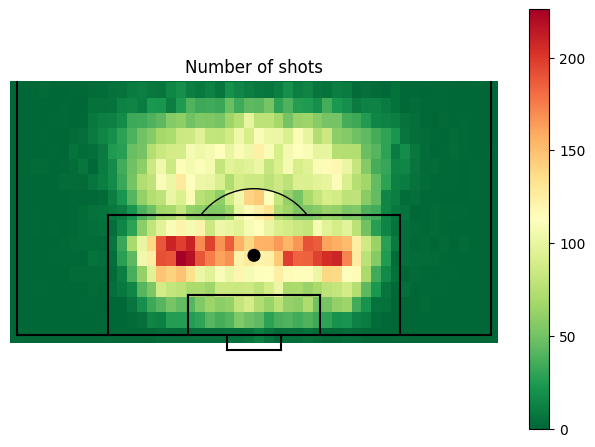

In [23]:
#Two dimensional histogram
H_Shot=np.histogram2d(shots_model['X'], shots_model['Y'],bins=50,range=[[0, 100],[0, 100]])
goals_only=shots_model[shots_model['Goal']==1]
H_Goal=np.histogram2d(goals_only['X'], goals_only['Y'],bins=50,range=[[0, 100],[0, 100]])



#Plot the number of shots from different points
(fig,ax) = createGoalMouth()
pos=ax.imshow(H_Shot[0], extent=[-1,66,104,-1], aspect='auto',cmap=plt.cm.RdYlGn_r)
fig.colorbar(pos, ax=ax)
ax.set_title('Number of shots')
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

We can see that majority of the shots occured from within the box around the penalty spot area. Another thing we can see is that shots from flanks are very rare which is quite understandable as flanks are mostly used providing crosses or passes. Next let us visualize all the goal scoring locations.

## From Where Majority of Goals have Been Scored?

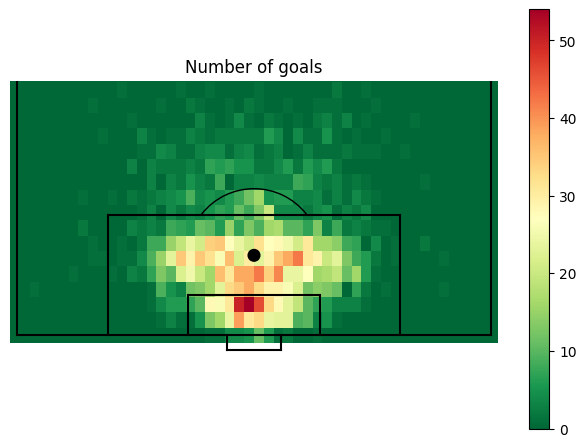

In [25]:
#Plot the number of GOALS from different points
(fig,ax) = createGoalMouth()
pos=ax.imshow(H_Goal[0], extent=[-1,66,104,-1], aspect='auto',cmap=plt.cm.RdYlGn_r)
fig.colorbar(pos, ax=ax)
ax.set_title('Number of goals')
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

fig.savefig('results/NumberOfGoals.pdf', dpi=None, bbox_inches="tight") 

The visual shows that of all the shots that were taken, shots from within the inner box are the most lethal. As distance or angle from the goal incerases, number of goals also decreases with very few goals from outside the box. No wonder goals from outside the box are a rarity (and absolute bilnders as well!). Next we plot the probability of scoring from different poitns on the pitch.

## Which Areas of the Pitch have the Highest Probability of Producing a Goal?

/var/folders/gl/8sp6_b_15m58yt5jq8bzjpjr0000gn/T/ipykernel_30883/434275583.py:3: RuntimeWarning: invalid value encountered in divide
  pos=ax.imshow(H_Goal[0]/H_Shot[0], extent=[-1,66,104,-1], aspect='auto',cmap=plt.cm.RdYlGn_r,vmin=0, vmax=0.5)


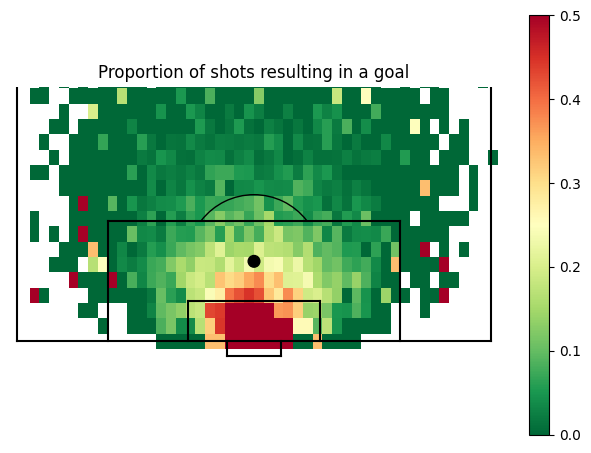

In [26]:
#Plot the probability of scoring from different points
(fig,ax) = createGoalMouth()
pos=ax.imshow(H_Goal[0]/H_Shot[0], extent=[-1,66,104,-1], aspect='auto',cmap=plt.cm.RdYlGn_r,vmin=0, vmax=0.5)
fig.colorbar(pos, ax=ax)
ax.set_title('Proportion of shots resulting in a goal')
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

At first sight the visual looks in order. But bit closer inspection reveals high probability spots (probability greater than 15%) in some unusual places. There is a very simple explanation for this anomaly. Now, probability of scoring a goal from a particular position is simply:

<b> Probability of Scoring from a psoition = Total Number of goals from the spot / Total number of shots from the spot </b>

So now consider a spot very far away from the goal. If very few people attempt a shot from the spot (e.g 5) and one of the shots results in a goals, this returns a probaility of 20% of scoring from the position. Hence, we see high proability goal scoring spots in some unsual areas because the number of shots attempted from those places are very low.

## From Which Angles Most Shots Have been Taken and Most Goals Have Been Scored?

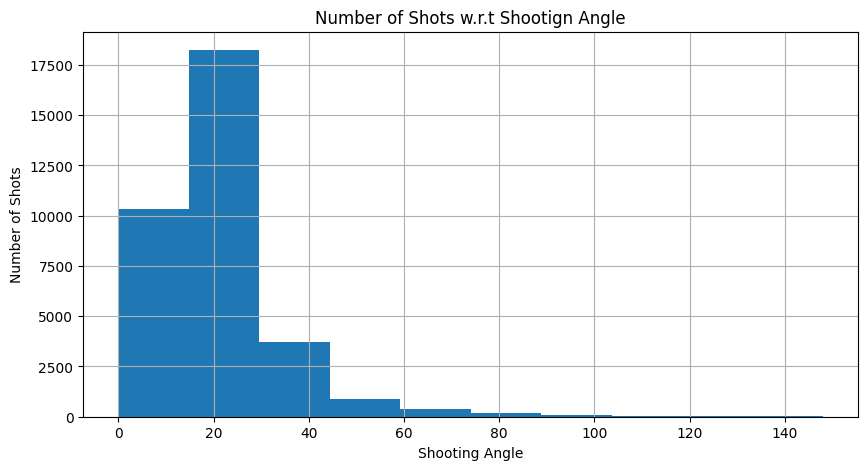

In [27]:
# Let us see a histogram of shots frequency from different angles
fig,ax = plt.subplots(figsize = (10,5))
shots_model.hist('Angle', ax = ax)

plt.title('Number of Shots w.r.t Shootign Angle')
plt.xlabel('Shooting Angle')
plt.ylabel('Number of Shots')
plt.show()

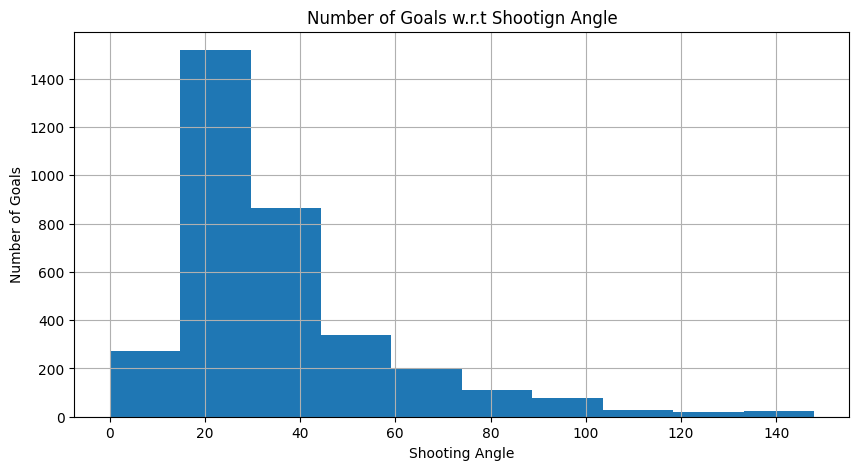

In [28]:
fig,ax = plt.subplots(figsize = (10,5))
shots_model[shots_model['Goal']== 1].hist('Angle', ax = ax)
plt.title('Number of Goals w.r.t Shootign Angle')
plt.xlabel('Shooting Angle')
plt.ylabel('Number of Goals')
plt.show()

## Goals Scored from Right Foot Comapred to Gaols Scored from Left Foot

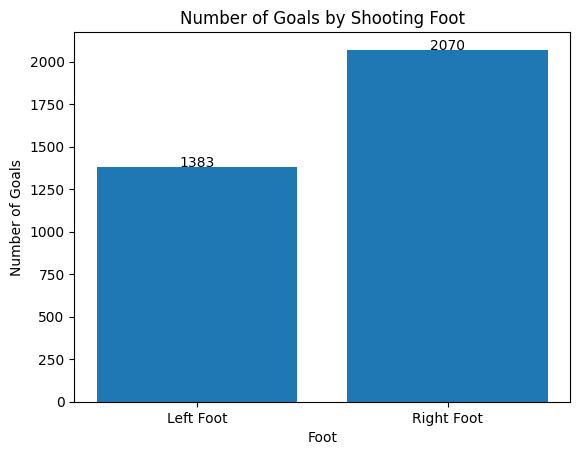

In [29]:
# Creating a mask to filter out all the goals
mask = shots_model[shots_model['Goal']== 1]

# Count the number of goals scored by left foot and right foot
left_foot_goals = mask['Left_Foot'].sum()
right_foot_goals = mask['Right_Foot'].sum()

# Plot the results
labels = ['Left Foot', 'Right Foot']
values = [left_foot_goals, right_foot_goals]
plt.bar(labels, values)
plt.title('Number of Goals by Shooting Foot')
plt.xlabel('Foot')
plt.ylabel('Number of Goals')

# Add text labels to the bars
for i, v in enumerate(values):
    plt.text(i, v + 0.25, str(v), color='black', ha='center')
    
plt.show()

## Goals Scored in 1st Half Comapred to Gaols Scored in Second

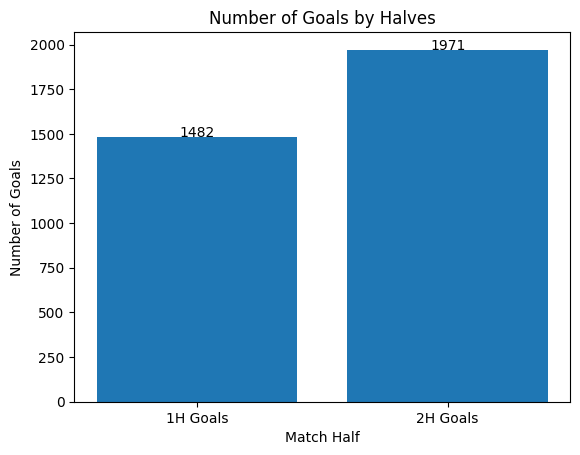

In [30]:
# Creating a mask to filter out all the goals
mask = shots_model[shots_model['Goal']== 1]

# Count the number of goals scored by left foot and right foot
FH_goals = mask['1H'].sum()
SH_goals = mask['2H'].sum()

# Plot the results
labels = ['1H Goals', '2H Goals']
values = [FH_goals, SH_goals]

plt.bar(labels, values)
plt.title('Number of Goals by Halves')
plt.xlabel('Match Half')
plt.ylabel('Number of Goals')

# Add text labels to the bars
for i, v in enumerate(values):
    plt.text(i, v + 0.25, str(v), color='black', ha='center')
plt.show()

## From Which Position in Goal Most Number of Goals Went in?

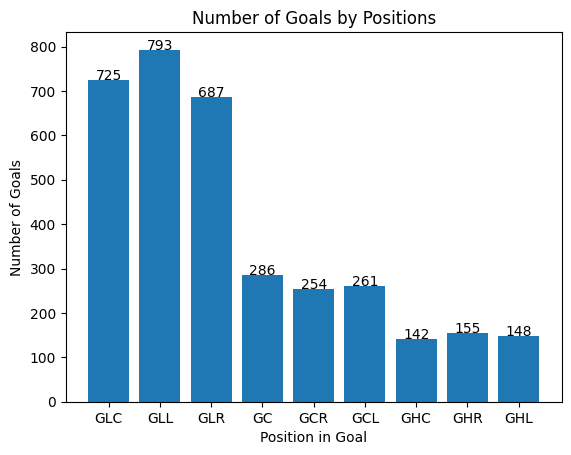

In [31]:
# Creating a mask to filter out all the goals
mask = shots_model[shots_model['Goal']== 1]

# Count the number of goals scored from different posittions
glc_goals = mask['GLC'].sum()
gll_goals = mask['GLL'].sum()
glr_goals = mask['GLR'].sum()
gc_goals  = mask['GC'].sum()
gcr_goals = mask['GCR'].sum()
gcl_goals = mask['GCL'].sum()
ghc_goals = mask['GHC'].sum()
ghr_goals = mask['GHR'].sum()
ghl_goals = mask['GHL'].sum()
# Plot the results
labels = ['GLC', 'GLL','GLR','GC','GCR','GCL','GHC','GHR','GHL']
values = [glc_goals, gll_goals, glr_goals,gc_goals,gcr_goals,gcl_goals,ghc_goals,ghr_goals,ghl_goals]

plt.bar(labels, values)
plt.title('Number of Goals by Positions')
plt.xlabel('Position in Goal')
plt.ylabel('Number of Goals')

# Add text labels to the bars
for i, v in enumerate(values):
    plt.text(i, v + 0.25, str(v), color='black', ha='center')
    
plt.show()

## Inspecting the Class Imbalance in our Data

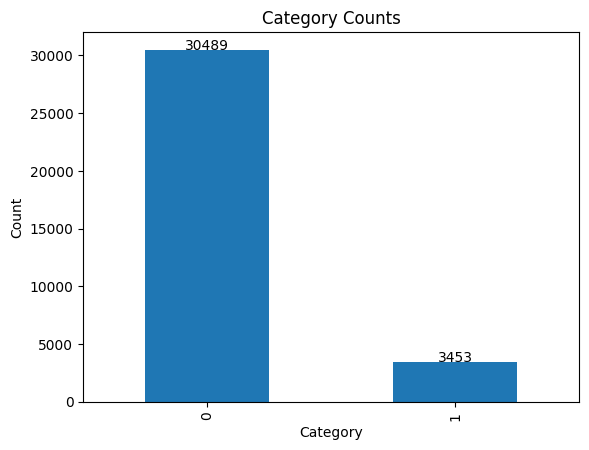

In [32]:
# Get the counts of each category
counts = shots_model['Goal'].value_counts()

# Create a bar plot
counts.plot.bar()

# Set the title and axis labels
plt.title('Category Counts')
plt.xlabel('Category')
plt.ylabel('Count')

# Add text labels to the bars
for i, v in enumerate(counts):
    plt.text(i, v + 0.25, str(v), color='black', ha='center')
# Display the plot
plt.show()

<b> Goal Class "1" </b>:                  3453

<b> No Goal Class "0" </b>:               30489

<b> Class Weights </b>: 

  - Class 1: 0.1017
  
  - Class 0: 0.8983

# <b>Checking for Multi-Collinearity in Data Using VIF Statistic</b>

In [33]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# VIF dataframe
features = shots_model[['X','Y','C','Left_Foot','Right_Foot','GLC', 'GLR', 'GLL', 'GC', 'GCR', 'GCL', 'GHC', 'GHR','GHL','1H', '2H', 'Player_Rank','Distance', 'Angle']]
vif_data = pd.DataFrame()
vif_data["feature"] = features.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(features.values, i)
                          for i in range(len(features.columns))]

pd.options.display.float_format = '{:.4f}'.format
vif_data

/Users/lorenzoguercio/Documents/Projects/Sport/XGoals_Project/venv_xgoals/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF
0,X,71.3179
1,Y,1.0233
2,C,6.7032
3,Left_Foot,inf
4,Right_Foot,inf
5,GLC,1.1287
6,GLR,1.0670
7,GLL,1.0729
8,GC,1.0617
9,GCR,1.0344


### Dealing with Infinity Values
We are getting the value "inf" (infinity) for 4 columns. Left_Foot, Right_Foot, 1H and 2H. This shows a perfect correlation between two independent variables. In the case of perfect correlation, we get R2 =1, which lead to 1/(1-R2) infinity. To solve this problem we need to drop one of the variables from the dataset which is causing this perfect multicollinearity. This also understandable since we always inlcude n-1 dummy variables for any categorical variable. Right_Foot class 0 represents Left_Foot, similiarly 1H class 0 represents 2H. Therefore, we will drop 1H and Left_Foot from our dataframe.

### Dealing with VIF Scores > 10
X coordinate and Distance are highly multicollinear, So we will be dropping X from our final dataset.

In [34]:
features = shots_model[['Y','C','Right_Foot','GLC', 'GLR', 'GLL', 'GC', 'GCR', 'GCL', 'GHC', 'GHR','GHL', '2H', 'Player_Rank','Distance', 'Angle']]
vif_data = pd.DataFrame()
vif_data["feature"] = features.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(features.values, i)
                          for i in range(len(features.columns))]

pd.options.display.float_format = '{:.4f}'.format
vif_data

,feature,VIF
0,Y,9.8181
1,C,3.9057
2,Right_Foot,2.5664
3,GLC,1.2635
4,GLR,1.1240
5,GLL,1.1360
6,GC,1.1179
7,GCR,1.0591
8,GCL,1.0571
9,GHC,1.0340


In [36]:
# Since VIF score for Y coordinate is aprox 10 so we also drop this feature. This will completely remove any trace of multi-collinearity from our data set
features = shots_model[['C','Right_Foot','GLC', 'GLR', 'GLL', 'GC', 'GCR', 'GCL', 'GHC', 'GHR','GHL', '2H', 'Player_Rank','Distance', 'Angle']]
vif_data = pd.DataFrame()
vif_data["feature"] = features.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(features.values, i)
                          for i in range(len(features.columns))]

pd.options.display.float_format = '{:.4f}'.format
vif_data

,feature,VIF
0,C,3.7726
1,Right_Foot,2.4928
2,GLC,1.2629
3,GLR,1.1185
4,GLL,1.1359
5,GC,1.1178
6,GCR,1.0564
7,GCL,1.0570
8,GHC,1.0340
9,GHR,1.0183


# <b>Train Test Split and Cross Validation </b>

In [37]:
# Creating a dataframe containing all the features
X = shots_model[['C','Right_Foot','GLC', 'GLR', 'GLL', 'GC', 'GCR', 'GCL', 'GHC', 'GHR','GHL', '2H', 'Player_Rank','Distance','Angle']]
# Feature data set
X

,C,Right_Foot,GLC,GLR,GLL,GC,GCR,GCL,GHC,GHR,GHL,2H,Player_Rank,Distance,Angle
0,9.0000,1,0,0,1,0,0,0,0,0,0,0,0.0255,13.8918,27.1841
1,2.0000,0,0,0,0,0,0,0,0,0,0,0,0.0069,15.8036,26.0022
2,17.0000,0,0,0,0,0,0,0,0,0,0,0,0.0341,22.8058,16.0770
3,20.0000,1,0,0,1,0,0,0,0,0,0,0,0.0341,29.2927,12.8159
4,11.0000,0,0,0,0,0,0,0,0,0,0,0,0.0214,12.7032,27.4476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33937,16.0000,1,0,0,0,0,0,0,0,0,0,1,0.0058,12.7351,19.8802
33938,18.0000,1,0,0,0,0,0,0,0,0,0,1,0.0058,15.7207,18.2019
33939,25.0000,0,0,0,1,0,0,0,0,0,0,1,-0.0059,18.2927,10.8363
33940,20.0000,1,0,0,0,0,1,0,0,0,0,1,0.0259,22.9393,15.0979


In [ ]:
# Scaling the numeric continous features in our data set
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_continuous = X[['C', 'Distance', 'Angle','Player_Rank']] # select only continuous columns
X_scaled = scaler.fit_transform(X_continuous)

X_scaled

array([[-0.43355223, -0.73871869,  0.44413802,  0.42703771],
       [-1.33526891, -0.50239097,  0.35154924, -0.34070708],
       [ 0.59698112,  0.363219  , -0.42597354,  0.78201649],
       ...,
       [ 1.62751447, -0.19468766, -0.83652799, -0.86904759],
       [ 0.98343113,  0.37971679, -0.50267458,  0.44354835],
       [-0.69118557, -0.79996597,  0.59010791, -0.91857951]],
      shape=(33942, 4))

In [41]:
# Dropping the original continuous columns in the dataframe
X = X.drop(['C','Player_Rank','Angle','Distance'], axis=1)

# Adding scaled columns to our dataset
X['C'] = X_scaled[:,0]
X['Distance'] = X_scaled[:,1]
X['Angle'] = X_scaled[:,2]
X['Player_Rank'] = X_scaled[:,3]

# Finalized Feature Dataset
X

,Right_Foot,GLC,GLR,GLL,GC,GCR,GCL,GHC,GHR,GHL,2H,C,Distance,Angle,Player_Rank
0,1,0,0,1,0,0,0,0,0,0,0,-0.4336,-0.7387,0.4441,0.4270
1,0,0,0,0,0,0,0,0,0,0,0,-1.3353,-0.5024,0.3515,-0.3407
2,0,0,0,0,0,0,0,0,0,0,0,0.5970,0.3632,-0.4260,0.7820
3,1,0,0,1,0,0,0,0,0,0,0,0.9834,1.1651,-0.6814,0.7820
4,0,0,0,0,0,0,0,0,0,0,0,-0.1759,-0.8856,0.4648,0.2578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33937,1,0,0,0,0,0,0,0,0,0,1,0.4682,-0.8817,-0.1280,-0.3861
33938,1,0,0,0,0,0,0,0,0,0,1,0.7258,-0.5126,-0.2595,-0.3861
33939,0,0,0,1,0,0,0,0,0,0,1,1.6275,-0.1947,-0.8365,-0.8690
33940,1,0,0,0,0,1,0,0,0,0,1,0.9834,0.3797,-0.5027,0.4435


In [42]:
# Creating a data set containing dependent variable 'Goal'
y = shots_model['Goal']

y

0        1
1        0
2        0
3        0
4        0
        ..
33937    0
33938    0
33939    1
33940    0
33941    0
Name: Goal, Length: 33942, dtype: int64

## Nested Cross-Validation

We first split the data into training and testing sets using train_test_split() and then use cross-validation on the training set to fine-tune the model's hyperparameters and estimate its performance. In nested cross-validation, the outer loop performs the train-test split and the inner loop performs cross-validation on the training set. The inner loop is used to search for the best hyperparameters for the model, while the outer loop is used to estimate the performance of the model on new data.

For imbalanced class data, it is generally recommended to use <b>stratified cross-validation</b>, which ensures that each fold has the same proportion of samples from each class as the entire dataset. This can help to ensure that the model is able to learn from examples of the minority class and improve its performance on predicting the minority class. <b> <i> Stratified k-fold cross-validation </i> </b>  is a common method for this, where the data is divided into k folds and each fold has roughly the same proportion of samples from each class.

# <b> Model # 1:          <u><i>Logistic Regression<i></u> </b>

In [43]:
# Importing the libraries required for logistci regression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score

In [44]:
# Loading required libraries
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score

In [45]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [47]:
# Determine scale_pos_weight based on class imbalance
count_class_0, count_class_1 = y_train.value_counts()
print ('Shot in Training Data: ', count_class_0)
print ('Goals in Training Data: ', count_class_1)

Shot in Training Data:  22817
Goals in Training Data:  2639


In [48]:
# Class imbalance in training data
weight_0 = count_class_0 / (count_class_0 + count_class_1)
weight_1 = count_class_1 / (count_class_0 + count_class_1)
print ('Weight of Shots Class in Training: ',weight_0)
print ('Weight of Goal Class in Training: ', weight_1)

Weight of Shots Class in Training:  0.896330923947203
Weight of Goal Class in Training:  0.10366907605279699


In [49]:
# Defining the hyperparameters to tune
# dictionary param_grid specifies the hyperparameters to tune for the logistic regression model. 
# The C parameter is the inverse of the regularization strength, penalty specifies the type of regularization to apply, and class_weight specifies
# how to handle class imbalance.
param_grid_lr = {'C': [0.1, 1, 10, 100],
              'penalty': ['l1', 'l2'],
              'class_weight': ['balanced', {0:weight_0, 1:weight_1}]}

In [50]:
# Defining the outer loop for train-test split
# This code defines the outer loop for cross-validation using StratifiedKFold(). 
# n_splits is the number of folds to use, and shuffle is whether or not to shuffle the data before splitting

cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [51]:
# Defining the inner loop for cross-validation on the training set
# This loop will be used to perform cross-validation on the training set for each combination of hyperparameters.
cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [52]:
# Defining the logistic regression model
lr_model = LogisticRegression()

We will now perform nested cross-validation using GridSearchCV() with the logistic regression model, the hyperparameter grid, the inner loop, and the F1 score as the performance metric. cross_val_score() is then used to calculate the F1 score of each fold in the outer loop.

The F-score is a way of combining the precision and recall of the model, and it is defined as the harmonic mean of the model’s precision and recall.

In [53]:
# Starting the tiemr
start_time = time.time()

# Perform nested cross-validation with grid search

grid = GridSearchCV(lr_model, param_grid=param_grid_lr, cv=cv_inner, scoring='f1', n_jobs=-1)
scores = cross_val_score(grid, X_train, y_train, cv=cv_outer, scoring='f1', n_jobs=-1)

# the array of F1-scores obtained by performing cross-validation on the training set using the GridSearchCV object
scores

/Users/lorenzoguercio/Documents/Projects/Sport/XGoals_Project/venv_xgoals/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
40 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/lorenzoguercio/Documents/Projects/Sport/XGoals_Project/venv_xgoals/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/lorenzoguercio/Documents/Projects/Sport/XGoals_Project/venv_xgoals/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args,

array([0.52570829, 0.53143159, 0.53232759, 0.54310345, 0.54039593])

The first value in scores (0.5257) represents the F1 score obtained when the best model was trained on the training data from the first split of cv_outer, and evaluated on the corresponding test data. Similarly, the second value in scores (0.5306) represents the F1 score obtained when the best model was trained on the training data from the second split of cv_outer, and evaluated on the corresponding test data, and so on. However, it is to be noted that we are dealing with inner loop only i.e. from within the training data we are furhter splitting the data into training and testing dataset.

In [54]:
# Fitting the best model on the entire training set
grid.fit(X_train, y_train)
best_lr_model = grid.best_estimator_

# Stopping the tiemr
end_time = time.time()

lr_training_time = end_time - start_time

/Users/lorenzoguercio/Documents/Projects/Sport/XGoals_Project/venv_xgoals/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
40 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/lorenzoguercio/Documents/Projects/Sport/XGoals_Project/venv_xgoals/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/lorenzoguercio/Documents/Projects/Sport/XGoals_Project/venv_xgoals/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args,

In [55]:
# Print the best parameters and training time
print("Best parameters: ", grid.best_params_)
print ("Model Training Time: {:.3f} seconds".format(lr_training_time))

Best parameters:  {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2'}
Model Training Time: 22.056 seconds


In [58]:
from tabulate import tabulate
from scipy.stats import norm

In [59]:
# Model Summary
# Get the estimated coefficients
coef = best_lr_model.coef_[0]
intercept = best_lr_model.intercept_[0]

# Calculate the standard errors
n = len(y_train)
A = np.hstack((np.ones((n, 1)), X_train))
p = len(coef)
y_pred = best_lr_model.predict(X_train)
residuals = y_train - y_pred
sigma2 = np.sum(residuals**2) / (n - p - 1)
cov = sigma2 * np.linalg.inv(np.dot(A.T, A))
se = np.sqrt(np.diag(cov)[1:])

# Calculate the Wald statistics and p-values
wald = coef / se
p_values = (1 - norm.cdf(np.abs(wald))) * 2

features = list(X_train.columns)

# Create a summary table of coefficients, standard errors, Wald statistics, and p-values
table = np.column_stack((features, coef, se, wald, p_values))
headers = ['Feature', 'Coef.', 'Std. Err.', 'Wald', 'p-value']
print(tabulate(table, headers=headers))

Feature           Coef.    Std. Err.       Wald    p-value
-----------  ----------  -----------  ---------  ---------
Right_Foot   -0.0674518   0.00533314   -12.6477          0
GLC           3.1987      0.00887006   360.617           0
GLR           4.45795     0.0119124    374.228           0
GLL           4.54077     0.01132      401.127           0
GC            3.00012     0.0122523    244.861           0
GCR           4.14258     0.0171035    242.207           0
GCL           4.11166     0.0166175    247.429           0
GHC           3.71801     0.0202119    183.952           0
GHR           4.8845      0.0281802    173.331           0
GHL           4.6849      0.0286568    163.483           0
2H            0.210382    0.0052149     40.3425          0
C            -0.143042    0.00304178   -47.0259          0
Distance     -0.473223    0.0036344   -130.207           0
Angle         0.496964    0.00402436   123.489           0
Player_Rank   0.161959    0.00276544    58.5656         

## Model Evaluation on Training Data

Text(0.5, 1.0, 'Confusion Matrix - Train Set')

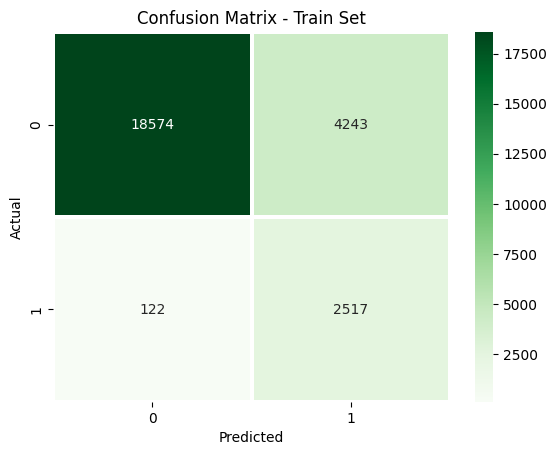

In [60]:
# Confusion Matrix for Training Data
cm_train = confusion_matrix(y_train, best_lr_model.predict(X_train))

ax = sns.heatmap(cm_train, annot=True, cmap='Greens', fmt='g', linewidth=1.5)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix - Train Set')

In [61]:
# Classfication report for training data
print (classification_report(y_train, best_lr_model.predict(X_train)))

              precision    recall  f1-score   support

           0       0.99      0.81      0.89     22817
           1       0.37      0.95      0.54      2639

    accuracy                           0.83     25456
   macro avg       0.68      0.88      0.72     25456
weighted avg       0.93      0.83      0.86     25456



## Model Evaluation on Testing Data

Text(0.5, 1.0, 'Confusion Matrix - Test Set')

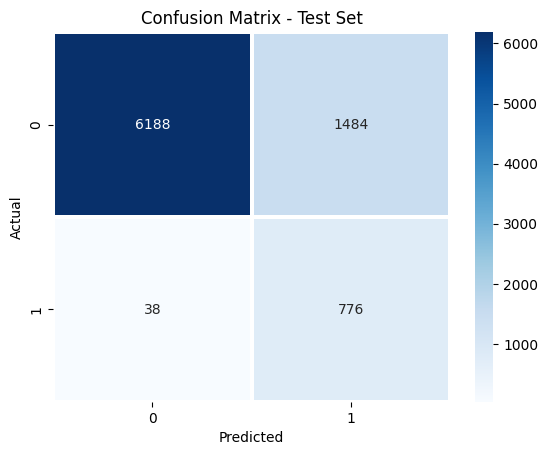

In [62]:
# Evaluate the performance of the best model on the testing set
y_pred = best_lr_model.predict(X_test)

# Confusion Matrix for Testig Data
cm_test = confusion_matrix(y_test, y_pred)

ax = sns.heatmap(cm_test, annot=True, cmap='Blues', fmt='g', linewidth=1.5)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix - Test Set')

In [63]:
# Classfication report for training data
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.81      0.89      7672
           1       0.34      0.95      0.50       814

    accuracy                           0.82      8486
   macro avg       0.67      0.88      0.70      8486
weighted avg       0.93      0.82      0.85      8486



## Interpretation of Results

We can see the classification results for both training and testing data sets are indentical which shows that model is not overfitting. Let us discuss in detail the results of model performance on testing data set.

<b><i>Model Accuracy: 0.82</i></b>

 - The accuracy of the model on the testing dataset is 0.82, which means that it predicts the correct class for 82% of total observations testing data.
 
 <b><i>Model Precision:</i></b>
 
 - Precision measures the proportion of true positives among all positive predictions. In other words, it measures how often the model is correct when it predicts positive.
 - For class 0, the precision is 0.99, which means that when the model predicts 0, it is almost always correct.
 - For class 1, the precision is 0.34, which means that when the model predicts 1, it is correct only 34% of the time.
 
 <b><i>Model Recall:</i></b>
 
 - Recall measures the proportion of true positives among all actual positives. In other words, it measures how often the model correctly identifies positive cases.
 - For class 0, the recall is 0.81, which means that the model identifies 81% of all actual 0 cases.
 - For class 1, the recall is 0.95, which means that the model identifies 95% of all actual 1 cases.
 
 <b><i>Final Word:</i></b>
 
The model has high recall for the positive class (class 1, GOAL), indicating that it is able to correctly identify a large proportion of shots that result in goals. However, the precision for class 1 is low, indicating that the model may also incorrectly classify many shots as resulting in goals. The overall accuracy of the model is 0.81, which is relatively high, but it is important to also consider the trade-off between precision and recall.

# <b> Model # 2:          <u><i>XG Boost<i></u> </b>
    
XGBoost is a popular boosting algorithm for classification tasks. Boosting is an ensemble technique where multiple models (weak learners) are combined to create a single strong model. XGBoost works by repeatedly fitting trees on the residuals of the previous iteration to improve the accuracy of the model. The key idea behind XGBoost is to add regularization to the base decision tree model to avoid overfitting.

Hyperparameters in XGBoost play a crucial role in determining the accuracy of the model. Some important hyperparameters include the learning rate, max depth of the tree, number of trees (n_estimators), and regularization parameters. The learning rate controls the step size at each iteration, the max depth of the tree controls the depth of the decision tree model, and the number of trees controls the number of trees to be built in the ensemble.

In [72]:
# importing libraries
import xgboost as xgb

In [73]:
# using the same approach for train test split and CV as before
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Defining the outer loop for train-test split
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Defining the inner loop for cross-validation on the training set
cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [74]:
# Define the xgboost model
xgb_model = xgb.XGBClassifier()

To address the issue of class imbalance, 

In [75]:
# Determine scale_pos_weight based on class imbalance
count_class_0, count_class_1 = y_train.value_counts()
print ('Shot in Training Data: ', count_class_0)
print ('Goals in Training Data: ', count_class_1)

Shot in Training Data:  22817
Goals in Training Data:  2639


In [76]:
# Class imbalance in training data
scale_pos_weight = count_class_0 / count_class_1
scale_pos_weight

8.646078059871163

In [77]:
# Defining the hyper-parameter grid for XG Boost
param_grid_xgb = {'learning_rate': [0.1, 0.01, 0.001],
              'max_depth': [3, 5, 7],
              'n_estimators': [100, 200, 300],
              'scale_pos_weight': [1, scale_pos_weight]}

<b>learning_rate</b>: Learning rate shrinks the contribution of each tree by the learning_rate factor. A smaller learning_rate allows the model to learn slower and prevents overfitting.

<b>max_depth</b>: Maximum depth of a tree. Increasing max_depth makes the model more complex and could lead to overfitting. A good starting point is to set it to a value between 3 to 10.

<b>n_estimators</b>: The number of trees in the forest. Increasing the number of trees can improve the model's performance, but also makes it slower to train.

<b>scale_pos_weight</b>: Control the balance of positive and negative weights. A value greater than 1 increases the weight of the positive class, which can be useful for imbalanced datasets.

In [78]:
# starting the timer

start_time = time.time()

# Perform nested cross-validation with grid search
grid_xg = GridSearchCV(xgb_model, param_grid=param_grid_xgb, cv=cv_inner, scoring='f1', n_jobs=-1)
scores_xg = cross_val_score(grid_xg, X_train, y_train, cv=cv_outer, scoring='f1', n_jobs=-1)

In [79]:
# Fit the best model on the entire training set
grid_xg.fit(X_train, y_train)
best_xgb_model = grid_xg.best_estimator_

# Stopping the timer
stop_time = time.time()

# Training Time
xgb_training_time = stop_time - start_time

In [80]:
# Print the best parameters and training time
print("Best parameters: ", grid_xg.best_params_)
print ("Model Training Time: {:.3f} seconds".format(xgb_training_time))

Best parameters:  {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'scale_pos_weight': 8.646078059871163}
Model Training Time: 35.819 seconds


## Model Evaluation on Training Data

Text(0.5, 1.0, 'Confusion Matrix - Train Set')

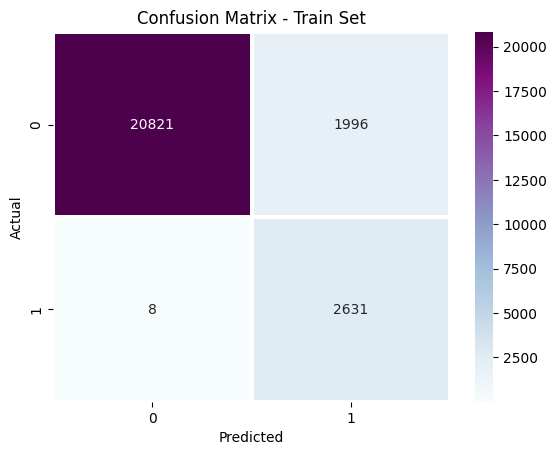

In [81]:
# Confusion Matrix for Training Data
cm_train_xg = confusion_matrix(y_train, best_xgb_model.predict(X_train))

ax = sns.heatmap(cm_train_xg, annot=True, cmap='BuPu', fmt='g', linewidth=1.5)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix - Train Set')

In [82]:
# Classfication report for training data
print (classification_report(y_train, best_xgb_model.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95     22817
           1       0.57      1.00      0.72      2639

    accuracy                           0.92     25456
   macro avg       0.78      0.95      0.84     25456
weighted avg       0.95      0.92      0.93     25456



## Model Evaluation on Testing Data

Text(0.5, 1.0, 'Confusion Matrix - Test Set')

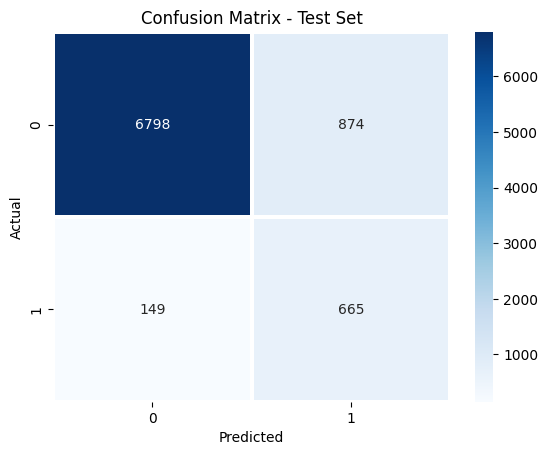

In [83]:
# Evaluate the performance of the best model on the testing set
y_pred_xgb = best_xgb_model.predict(X_test)

# Confusion Matrix for Testig Data
cm_test_xgb = confusion_matrix(y_test, y_pred_xgb)

ax = sns.heatmap(cm_test_xgb, annot=True, cmap='Blues', fmt='g', linewidth=1.5)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix - Test Set')

In [84]:
# Classfication report for testing data
print (classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.98      0.89      0.93      7672
           1       0.43      0.82      0.57       814

    accuracy                           0.88      8486
   macro avg       0.71      0.85      0.75      8486
weighted avg       0.93      0.88      0.90      8486



## Interpreatation of Results

We can see the classification results for both training and testing data sets are indentical which shows that model is not overfitting. Let us discuss in detail the results of model performance on testing data set.

<b><i>Model Accuracy: 0.8</i></b>

 - The accuracy of the model on the testing dataset is 0.88, which means that it predicts the correct class for 88% of total observations testing data.
 
 <b><i>Model Precision:</i></b>
 
 - Precision measures the proportion of true positives among all positive predictions. In other words, it measures how often the model is correct when it predicts positive.
 - For class 0, the precision is 0.98, which means that when the model predicts 0, it is almost always correct.
 - For class 1, the precision is 0.43, which means that when the model predicts 1, it is correct only 43% of the time.
 
 <b><i>Model Recall:</i></b>
 
 - Recall measures the proportion of true positives among all actual positives. In other words, it measures how often the model correctly identifies positive cases.
 - For class 0, the recall is 0.89, which means that the model identifies 89% of all actual 0 cases.
 - For class 1, the recall is 0.81, which means that the model identifies 81% of all actual 1 cases.
 
 <b><i>Final Word:</i></b>
 
The model has high recall for the positive class (class 1, GOAL), indicating that it is able to correctly identify a large proportion of shots that result in goals. However, the precision for class 1 is low, indicating that the model may also incorrectly classify many shots as resulting in goals.

In comparison to logistic regression model, XG Boost model provides better precision on testing data (43% as compared to 34%) for class 1. On the other hand, recall for XG Boost model has decreased from 95%, for logistic regression model for Class 1, to 81%. In short, when XG Boost model is more accurate than logistic regression model when it comes to predicts a shot to be goal but its ability all shots that result in goal is less than that of logistic regression model. 

## Plotting Feature Importance



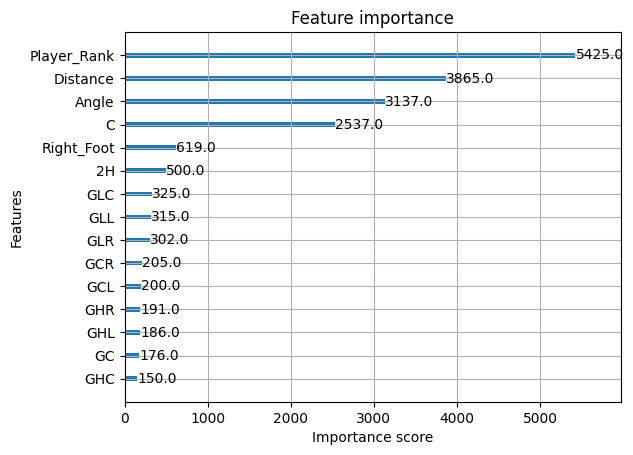

In [85]:
# Plot feature importance
xgb.plot_importance(best_xgb_model)
plt.show()

We can also plot feature importance using two parameters:

- weight: The 'weight' option displays the number of times each feature appears in a tree

- gain: the 'gain' option displays the average gain of each feature when it is used in a tree

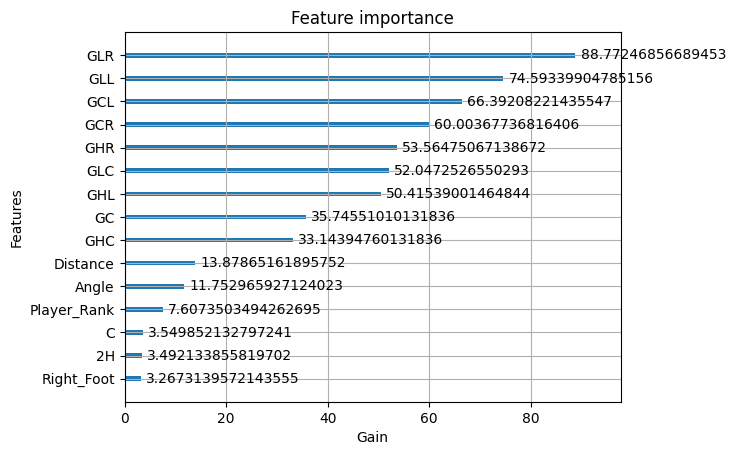

In [86]:
xgb.plot_importance(best_xgb_model, importance_type='gain', xlabel='Gain')
plt.show()

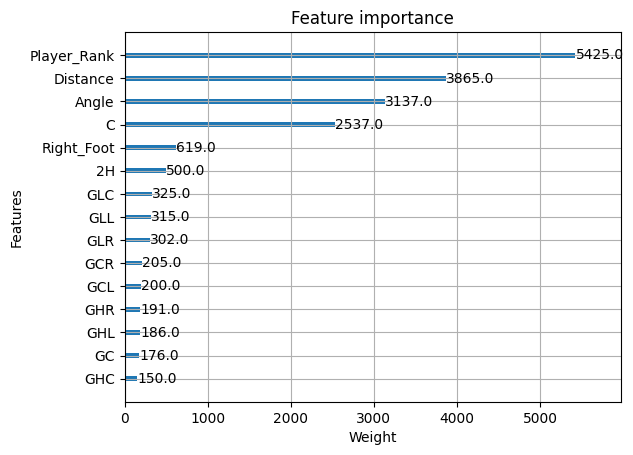

In [87]:
xgb.plot_importance(best_xgb_model, importance_type='weight', xlabel='Weight')
plt.show()

# <b>Model # 3:          <u><i>Random Forests<i></u> </b>
    
Random forests for classification is an ensemble learning method that combines multiple decision trees. Each decision tree is trained on a random subset of the training data and a random subset of the features. The final prediction is made by aggregating the predictions of all the individual trees. This method is robust against overfitting, and it can handle both categorical and numerical data. The hyperparameters to tune include the number of trees, the maximum depth of the trees, and the size of the random subsets.

In [88]:
from sklearn.ensemble import RandomForestClassifier

In [89]:
# using the same approach for train test split and CV as before
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Defining the outer loop for train-test split
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Defining the inner loop for cross-validation on the training set
cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [90]:
# Determine scale_pos_weight based on class imbalance
count_class_0, count_class_1 = y_train.value_counts()
# Class imbalance in training data
weight_0 = count_class_0 / (count_class_0 + count_class_1)
weight_1 = count_class_1 / (count_class_0 + count_class_1)
print ('Weight of Shots Class in Training: ',weight_0)
print ('Weight of Goal Class in Training: ', weight_1)

Weight of Shots Class in Training:  0.896330923947203
Weight of Goal Class in Training:  0.10366907605279699


<b> Hyperparameters for Random Forests </b>

- n_estimators: This parameter controls the number of decision trees in the forest. Increasing this number can lead to better performance, but it also increases the training time and the risk of overfitting.

- max_depth: This parameter controls the maximum depth of each decision tree in the forest. Deeper trees can capture more complex relationships in the data, but they can also overfit. Setting a lower value for max_depth can help prevent overfitting.

- min_samples_split: This parameter controls the minimum number of samples required to split an internal node in each decision tree. Increasing this value can help prevent overfitting by ensuring that each split is based on a sufficient number of samples.

- class_weight: This parameter can be used to adjust the class weights in the model. If set to 'balanced', the model will automatically adjust the weights based on the number of samples in each class. If set to a dictionary of class weights, it will use the specified weights. This can be useful when dealing with imbalanced classes, where one class has many more samples than the other.

In [91]:
# Define the hyperparameters to tune
param_grid = {'n_estimators': [100, 200, 300],
              'max_depth': [3, 5, 7,9, 12, 15],
              'min_samples_split': [2, 5, 10],
              'class_weight': ['balanced', {0: weight_0, 1: weight_1}]}

In [92]:
# Define the random forest model
rf_model = RandomForestClassifier()

In [93]:
start_time = time.time()
# Perform nested cross-validation with grid search
grid_rf = GridSearchCV(rf_model, param_grid=param_grid, cv=cv_inner, scoring='f1', n_jobs=-1)
scores_rf = cross_val_score(grid, X_train, y_train, cv=cv_outer, scoring='f1', n_jobs=-1)

/Users/lorenzoguercio/Documents/Projects/Sport/XGoals_Project/venv_xgoals/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
40 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/lorenzoguercio/Documents/Projects/Sport/XGoals_Project/venv_xgoals/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/lorenzoguercio/Documents/Projects/Sport/XGoals_Project/venv_xgoals/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args,

In [94]:
# Fit the best model on the entire training set
grid_rf.fit(X_train, y_train)
best_rf_model = grid_rf.best_estimator_

end_time = time.time()

rf_training_time = end_time - start_time

In [95]:
# Print the best parameters
print("Best parameters: ", grid_rf.best_params_)
print ("Model Training Time: {:.3f} seconds".format(rf_training_time))

Best parameters:  {'class_weight': 'balanced', 'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 200}
Model Training Time: 93.323 seconds


## Model Performance on Training

Text(0.5, 1.0, 'Confusion Matrix - Train Set')

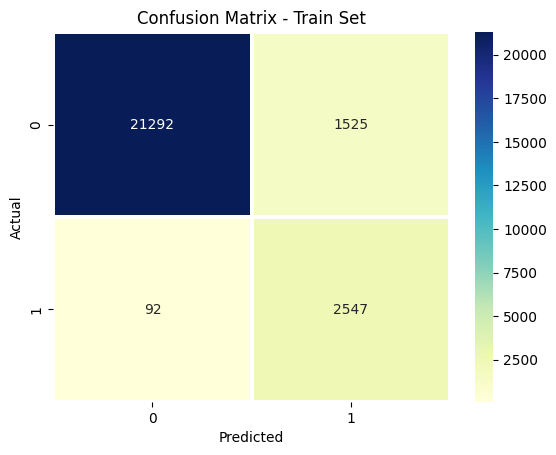

In [96]:
# Confusion Matrix for Training Data
cm_train_rf = confusion_matrix(y_train, best_rf_model.predict(X_train))

ax = sns.heatmap(cm_train_rf, annot=True, cmap='YlGnBu', fmt='g', linewidth=1.5)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix - Train Set')

In [97]:
# Classfication report for training data
print (classification_report(y_train, best_rf_model.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96     22817
           1       0.63      0.97      0.76      2639

    accuracy                           0.94     25456
   macro avg       0.81      0.95      0.86     25456
weighted avg       0.96      0.94      0.94     25456



## Model Performance in Testing

Text(0.5, 1.0, 'Confusion Matrix - Test Set')

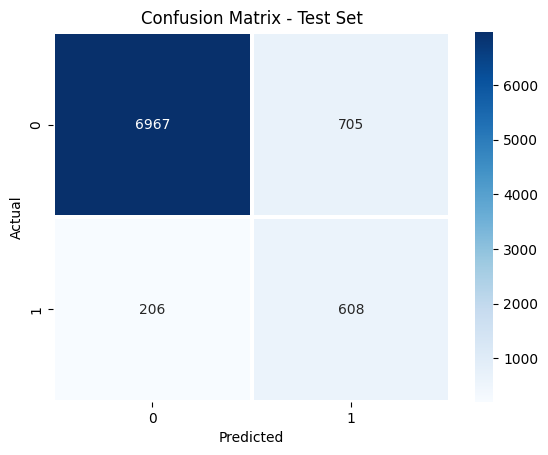

In [98]:
# Evaluate the performance of the best model on the testing set
y_pred_rf = best_rf_model.predict(X_test)

# Confusion Matrix for Testig Data
cm_test_rf = confusion_matrix(y_test, y_pred_rf)

ax = sns.heatmap(cm_test_rf, annot=True, cmap='Blues', fmt='g', linewidth=1.5)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix - Test Set')

In [99]:
# Classfication report for testing data
print (classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94      7672
           1       0.46      0.75      0.57       814

    accuracy                           0.89      8486
   macro avg       0.72      0.83      0.76      8486
weighted avg       0.92      0.89      0.90      8486



## Interpretation of Results 

- When random forests model predicts that a shot will result in a goal, it is right 47% of the times. hence, its precision is better than both logistic regression and xg boost model.
- While its precision is better, of all the shots that resulted in a goal, random forest model was able to capture only 74% i,e. its recall is lower than both logistic regression and xg boost. The increase in precision comes at a cost i.e. loss in recall


## Plotting Feature Importance

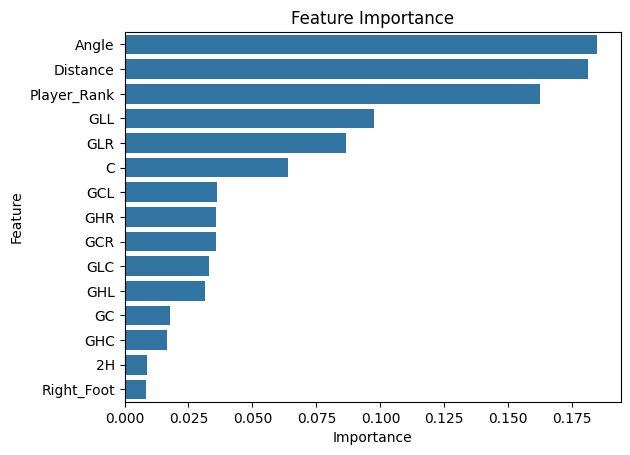

In [100]:
# Extract feature importances
importances = best_rf_model.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X_train.columns[i] for i in indices]

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Create barplot using seaborn
sns.barplot(x=importances[indices], y=names)

# Add x and y axis labels
plt.xlabel("Importance")
plt.ylabel("Feature")

# Show plot
plt.show()

# <b>Model # 4:          <u><i>Support Vector Machines<i></u> </b>
    
Support Vector Machine (SVM) is a supervised machine learning algorithm used for classification and regression analysis. SVM tries to find a hyperplane that best separates the data into different classes. The algorithm tries to maximize the margin between the hyperplane and the closest data points of each class. SVM can handle linear and non-linear data using different types of kernels such as linear, polynomial, and radial basis function (RBF).

In [101]:
from sklearn.svm import SVC

In [102]:
## Cross Validation and train test split
# using the same approach for train test split and CV as before
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Defining the outer loop for train-test split
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Defining the inner loop for cross-validation on the training set
cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### Hyperparameters to be Tuned

- Kernel: the kernel function is used to transform the input data into higher dimensions in order to find the optimal boundary. Some commonly used kernel functions are linear, polynomial, and radial basis function (RBF).

- C: the penalty parameter that controls the trade-off between misclassification of training examples and smoothness of the decision boundary. A smaller value of C creates a wider margin but allows more misclassifications, while a larger value of C creates a narrower margin but allows fewer misclassifications.

- gamma: a parameter that controls the width of the Gaussian kernel in the RBF function. A smaller value of gamma creates a wider Gaussian bell-shaped curve, while a larger value of gamma creates a narrower curve that focuses on closer data points.

- Class weight: a parameter used to give more weight to certain classes in case of imbalanced data.

In [103]:
# Define the hyperparameters to tune
param_grid = {'C': [0.1, 1, 10],
              'kernel': ['linear', 'rbf', 'sigmoid'],
              'gamma': ['scale', 'auto'],
              'class_weight': ['balanced', {0: weight_0, 1: weight_1}]}

In [104]:
# Define the SVM model
svm_model = SVC()

# Starting the timer
start_time = time.time()

# Perform nested cross-validation with grid search
grid_svm = GridSearchCV(svm_model, param_grid=param_grid, cv=cv_inner, scoring='f1', n_jobs=-1)
scores_svm = cross_val_score(grid_svm, X_train, y_train, cv=cv_outer, scoring='f1', n_jobs=-1)

In [105]:
# Fit the best model on the entire training set
grid_svm.fit(X_train, y_train)
best_svm_model = grid_svm.best_estimator_

# stopping the timer
stop_time = time.time()
svm_training_time = stop_time - start_time

In [106]:
# Print the best parameters
print("Best parameters: ", grid_svm.best_params_)
print ("Model Training Time: {:.3f} seconds".format(svm_training_time))

Best parameters:  {'C': 10, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}
Model Training Time: 386.877 seconds


## Model Performance in Training

Text(0.5, 1.0, 'Confusion Matrix - Train Set')

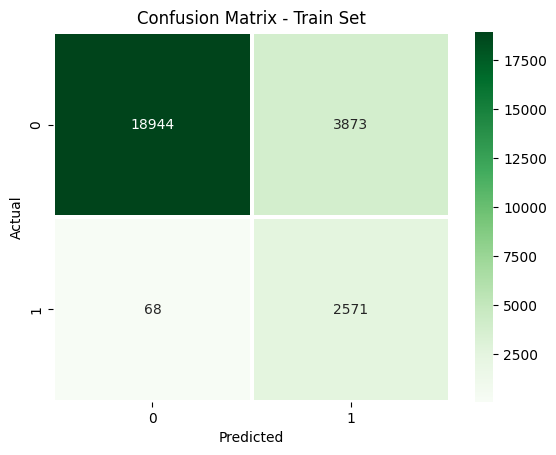

In [107]:
# Confusion Matrix for Training Data
cm_train_svm = confusion_matrix(y_train, best_svm_model.predict(X_train))

ax = sns.heatmap(cm_train_svm, annot=True, cmap='Greens', fmt='g', linewidth=1.5)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix - Train Set')

In [108]:
# Classfication report for training data
print (classification_report(y_train, best_svm_model.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      0.83      0.91     22817
           1       0.40      0.97      0.57      2639

    accuracy                           0.85     25456
   macro avg       0.70      0.90      0.74     25456
weighted avg       0.93      0.85      0.87     25456



## Model Performance in Testing

Text(0.5, 1.0, 'Confusion Matrix - Test Set')

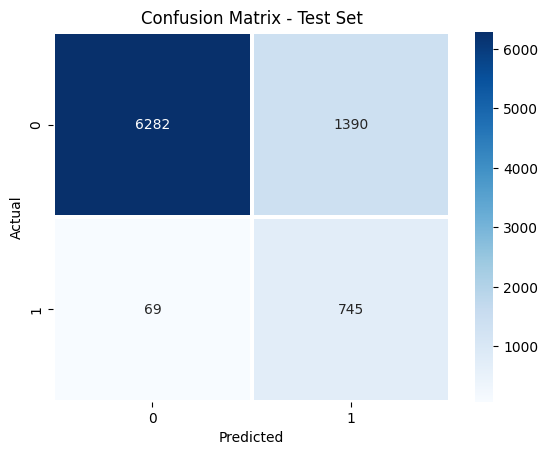

In [109]:
# Evaluate the performance of the best model on the testing set
y_pred_svm = best_svm_model.predict(X_test)

# Confusion Matrix for Testig Data
cm_test_svm = confusion_matrix(y_test, y_pred_svm)

ax = sns.heatmap(cm_test_svm, annot=True, cmap='Blues', fmt='g', linewidth=1.5)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix - Test Set')

In [110]:
# Classfication report for testing data
print (classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.99      0.82      0.90      7672
           1       0.35      0.92      0.51       814

    accuracy                           0.83      8486
   macro avg       0.67      0.87      0.70      8486
weighted avg       0.93      0.83      0.86      8486



# <b>Summary and Comparison of Classification Results</b>

In [111]:
# Precision scores for the four models on training data
prec_lr_train = precision_score(y_train, best_lr_model.predict(X_train))

prec_xgb_train = precision_score(y_train, best_xgb_model.predict(X_train))

prec_rf_train = precision_score(y_train, best_rf_model.predict(X_train))

prec_svm_train = precision_score(y_train, best_svm_model.predict(X_train))

prec_train = [prec_lr_train, prec_xgb_train, prec_rf_train, prec_svm_train]

# Precision scores for the four models on testing data
prec_lr_test = precision_score(y_test, y_pred)

prec_xgb_test = precision_score(y_test, y_pred_xgb)

prec_rf_test = precision_score(y_test, y_pred_rf)

prec_svm_test = precision_score(y_test, y_pred_svm)

prec_test = [prec_lr_test, prec_xgb_test, prec_rf_test, prec_svm_test]

# Recall scores for the four models on training data
rec_lr_train = recall_score(y_train, best_lr_model.predict(X_train))

rec_xgb_train = recall_score(y_train, best_xgb_model.predict(X_train))

rec_rf_train = recall_score(y_train, best_rf_model.predict(X_train))

rec_svm_train = recall_score(y_train, best_svm_model.predict(X_train))

rec_train = [rec_lr_train, rec_xgb_train, rec_rf_train, rec_svm_train]


# Calculting Recall for the four models on test data
rec_lr_test = recall_score(y_test, y_pred)

rec_xgb_test = recall_score(y_test, y_pred_xgb)

rec_rf_test = recall_score(y_test, y_pred_rf)

rec_svm_test = recall_score(y_test, y_pred_svm)

rec_test = [rec_lr_test, rec_xgb_test, rec_rf_test, rec_svm_test]

# Accuracy scores for the four models on training data
acc_lr_train = accuracy_score(y_train, best_lr_model.predict(X_train))

acc_xgb_train = accuracy_score(y_train, best_xgb_model.predict(X_train))

acc_rf_train = accuracy_score(y_train, best_rf_model.predict(X_train))

acc_svm_train = accuracy_score(y_train, best_svm_model.predict(X_train))

acc_train = [acc_lr_train, acc_xgb_train, acc_rf_train, acc_svm_train]

# Calculating Accuracy for the four models on test data
acc_lr_test = accuracy_score(y_test, y_pred)

acc_xgb_test = accuracy_score(y_test, y_pred_xgb)

acc_rf_test = accuracy_score(y_test, y_pred_rf)

acc_svm_test = accuracy_score(y_test, y_pred_svm)

acc_test = [acc_lr_test, acc_xgb_test, acc_rf_test, acc_svm_test]

# Model training time
train_time =[lr_training_time/60, xgb_training_time/60, rf_training_time/60, svm_training_time/60]

In [114]:
# Creating of dataframe of summary results
summary_df = pd.DataFrame({'Model Name':['Logistic Regression','XG Boost','Random Forests','SVM'],
                          'Training Accuracy': acc_train, 'Training Precision': prec_train,'Training Recall':rec_train,
                          'Testing Accuracy': acc_test, 'Testing Precision': prec_test,'Testing Recall':rec_test,
                          'Training Time (mins)': train_time})

summary_df.set_index('Model Name', inplace=True)
# Displaying summary of results
summary_df.style.format(precision =3).highlight_max(color='cyan').set_properties(**{'font-weight': 'bold',
            'border': '2.0px solid grey','color': 'purple'}).highlight_min(color='yellow')

,Training Accuracy,Training Precision,Training Recall,Testing Accuracy,Testing Precision,Testing Recall,Training Time (mins)
Model Name,,,,,,,
Logistic Regression,0.829,0.372,0.954,0.821,0.343,0.953,0.368
XG Boost,0.921,0.569,0.997,0.879,0.432,0.817,0.597
Random Forests,0.936,0.625,0.965,0.893,0.463,0.747,1.555
SVM,0.845,0.399,0.974,0.828,0.349,0.915,6.448
